In [33]:
!pip install requests
!pip install tabulate
!pip install "colorama>=0.3.8"
!pip install future
!pip install h2o

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Dataset Link
https://www.kaggle.com/datasets/miteshsingh11/uber-lyft-dataset-for-dsem-33201

# Assignment 2 Auto ML

* Is the relationship significant?

* Are any model assumptions violated?

* Is there any multicollinearity in the model?

* In the multivariate models are predictor variables independent of all the other predictor variables?

* In in multivariate models rank the most significant predictor variables and exclude insignificant ones from the model.

* Does the model make sense?

* Does regularization help?

* Which independent variables are significant?

* Which hyperparameters are important?

In [34]:
import h2o
from h2o.automl import H2OAutoML
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.grid.grid_search import H2OGridSearch
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.estimators.random_forest import H2ORandomForestEstimator
from h2o.estimators.deeplearning import H2ODeepLearningEstimator
from tabulate import tabulate
from h2o.automl import H2OAutoML
from datetime import datetime
import random, os, sys
import pandas as pd
import logging
import csv
import optparse
import time
import json
from distutils.util import strtobool
import psutil
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import matplotlib
import seaborn as sns
import operator



In [35]:
# Setting up maximum runtime for the AutoML
min_mem_size = 6
run_time = 222

In [36]:
pct_memory = 0.5
virtual_memory = psutil.virtual_memory()
min_mem_size = int(round(int(pct_memory * virtual_memory.available) / 1073741824, 0))
print(min_mem_size)

3


In [37]:
# 65535 Highest port no
# Start the H2O server on a random port
port_no = random.randint(5555, 55555)

#  h2o.init(strict_version_check=False,min_mem_size_GB=min_mem_size,port=port_no) # start h2o
try:
    h2o.init(
        strict_version_check=False, min_mem_size_GB=min_mem_size, port=port_no
    )  # start h2o
except:
    logging.critical("h2o.init")
    h2o.download_all_logs(dirname=logs_path, filename=logfile)
    h2o.cluster().shutdown()
    sys.exit(2)

Checking whether there is an H2O instance running at http://localhost:24090..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.17" 2022-10-18; OpenJDK Runtime Environment (build 11.0.17+8-post-Ubuntu-1ubuntu220.04); OpenJDK 64-Bit Server VM (build 11.0.17+8-post-Ubuntu-1ubuntu220.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.8/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpw8rhgiva
  JVM stdout: /tmp/tmpw8rhgiva/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpw8rhgiva/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:24090
Connecting to H2O server at http://127.0.0.1:24090 ... successful.


--------------------------  ----------------------------------
H2O_cluster_uptime:         08 secs
H2O_cluster_timezone:       Etc/UTC
H2O_data_parsing_timezone:  UTC
H2O_cluster_version:        3.40.0.1
H2O_cluster_version_age:    20 days
H2O_cluster_name:           H2O_from_python_unknownUser_ctd6rg
H2O_cluster_total_nodes:    1
H2O_cluster_free_memory:    3.172 Gb
H2O_cluster_total_cores:    2
H2O_cluster_allowed_cores:  2
H2O_cluster_status:         locked, healthy
H2O_connection_url:         http://127.0.0.1:24090
H2O_connection_proxy:       {"http": null, "https": null}
H2O_internal_security:      False
Python_version:             3.8.10 final
--------------------------  ----------------------------------

In [38]:
pandas_df = pd.read_csv('/content/drive/MyDrive/uber_lyft.csv')

In [39]:
pandas_df.head()

id     timestamp  hour  day  month  \
0  424553bb-7174-41ea-aeb4-fe06d4f4b9d7  1.544953e+09     9   16     12   
1  4bd23055-6827-41c6-b23b-3c491f24e74d  1.543284e+09     2   27     11   
2  981a3613-77af-4620-a42a-0c0866077d1e  1.543367e+09     1   28     11   
3  c2d88af2-d278-4bfd-a8d0-29ca77cc5512  1.543554e+09     4   30     11   
4  e0126e1f-8ca9-4f2e-82b3-50505a09db9a  1.543463e+09     3   29     11   

        datetime          timezone            source    destination cab_type  \
0  12/16/18 9:30  America/New_York  Haymarket Square  North Station     Lyft   
1  11/27/18 2:00  America/New_York  Haymarket Square  North Station     Lyft   
2  11/28/18 1:00  America/New_York  Haymarket Square  North Station     Lyft   
3  11/30/18 4:53  America/New_York  Haymarket Square  North Station     Lyft   
4  11/29/18 3:49  America/New_York  Haymarket Square  North Station     Lyft   

   ... precipIntensityMax uvIndexTime  temperatureMin  temperatureMinTime  \
0  ...             0.1276  1544979600           39.89          1545012000   
1  ...             0.1300  1543251600           40.49          1543233600   
2  ...             0.1064  1543338000           35.36          1543377600   
3  ...             0.0000  1543507200           34.67          1543550400   
4  ...             0.0001  1543420800           33.10          1543402800   

   temperatureMax  temperatureMaxTime  apparentTemperatureMin  \
0           43.68          1544968800                   33.73   
1           47.30          1543251600                   36.20   
2           47.55          1543320000                   31.04   
3           45.03          1543510800                   30.30   
4           42.18          1543420800                   29.11   

   apparentTemperatureMinTime  Unnamed: 55 Unnamed: 56  
0                  1545012000        38.07  1544958000  
1                  1543291200        43.92  1543251600  
2                  1543377600        44.12  1543320000  
3                  1543550400        38.53  1543510800  
4                  1543392000        35.75  1543420800  

[5 rows x 57 columns]

In [40]:
pandas_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60392 entries, 0 to 60391
Data columns (total 57 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           60392 non-null  object 
 1   timestamp                    60392 non-null  float64
 2   hour                         60392 non-null  int64  
 3   day                          60392 non-null  int64  
 4   month                        60392 non-null  int64  
 5   datetime                     60392 non-null  object 
 6   timezone                     60392 non-null  object 
 7   source                       60392 non-null  object 
 8   destination                  60392 non-null  object 
 9   cab_type                     60392 non-null  object 
 10  product_id                   60392 non-null  object 
 11  name                         60392 non-null  object 
 12  price                        60392 non-null  float64
 13  distance        

In [41]:
pandas_df.isna().sum()

id                             0
timestamp                      0
hour                           0
day                            0
month                          0
datetime                       0
timezone                       0
source                         0
destination                    0
cab_type                       0
product_id                     0
name                           0
price                          0
distance                       0
surge_multiplier               0
latitude                       0
longitude                      0
temperature                    0
apparentTemperature            0
short_summary                  0
long_summary                   0
precipIntensity                0
precipProbability              0
humidity                       0
windSpeed                      0
windGust                       0
windGustTime                   0
visibility                     0
temperatureHigh                0
temperatureHighTime            0
temperatur

In [42]:
pandas_df.describe()

timestamp          hour           day         month         price  \
count  6.039200e+04  60392.000000  60392.000000  60392.000000  60392.000000   
mean   1.544034e+09     11.560372     17.989369     11.574778     16.558311   
std    7.009720e+05      6.979898      9.986021      0.494381      9.334517   
min    1.543204e+09      0.000000      1.000000     11.000000      2.500000   
25%    1.543441e+09      5.000000     13.000000     11.000000      9.000000   
50%    1.543724e+09     12.000000     17.000000     12.000000     13.500000   
75%    1.544816e+09     18.000000     28.000000     12.000000     22.500000   
max    1.550000e+09     23.000000     30.000000     12.000000     92.000000   

           distance  surge_multiplier      latitude     longitude  \
count  60392.000000      60392.000000  60392.000000  60392.000000   
mean       2.186802          1.016219     42.338232    -71.066179   
std        1.133206          0.097512      0.047746      0.020275   
min        0.020000          1.000000     42.214800    -71.105400   
25%        1.270000          1.000000     42.350300    -71.081000   
50%        2.150000          1.000000     42.351900    -71.063100   
75%        2.930000          1.000000     42.364700    -71.054200   
max        7.460000          2.500000     42.366100    -71.033000   

        temperature  ...  precipIntensityMax   uvIndexTime  temperatureMin  \
count  60392.000000  ...        60392.000000  6.039200e+04    60392.000000   
mean      39.545920  ...            0.037199  1.544030e+09       33.464559   
std        6.707104  ...            0.055212  6.891746e+05        6.478175   
min       18.910000  ...            0.000000  1.543162e+09       15.630000   
25%       36.500000  ...            0.000000  1.543421e+09       30.170000   
50%       40.490000  ...            0.000400  1.543684e+09       34.220000   
75%       43.580000  ...            0.091600  1.544807e+09       38.880000   
max       57.220000  ...            0.145900  1.545152e+09       43.100000   

       temperatureMinTime  temperatureMax  temperatureMaxTime  \
count        6.039200e+04    60392.000000        6.039200e+04   
mean         1.544027e+09       45.214856        1.544033e+09   
std          6.883356e+05        5.619043        6.880449e+05   
min          1.543122e+09       33.510000        1.543154e+09   
25%          1.543399e+09       42.570000        1.543439e+09   
50%          1.543666e+09       44.660000        1.543691e+09   
75%          1.544789e+09       46.910000        1.544814e+09   
max          1.545192e+09       57.870000        1.545109e+09   

       apparentTemperatureMin  apparentTemperatureMinTime   Unnamed: 55  \
count            60392.000000                6.039200e+04  60392.000000   
mean                29.743774                1.544034e+09     41.909177   
std                  7.093760                6.852014e+05      6.915854   
min                 11.810000                1.543136e+09     28.950000   
25%                 27.760000                1.543399e+09     36.570000   
50%                 30.130000                1.543662e+09     40.950000   
75%                 35.710000                1.544789e+09     44.060000   
max                 40.050000                1.545134e+09     57.200000   

        Unnamed: 56  
count  6.039200e+04  
mean   1.544034e+09  
std    6.890253e+05  
min    1.543187e+09  
25%    1.543439e+09  
50%    1.543691e+09  
75%    1.544818e+09  
max    1.545109e+09  

[8 rows x 46 columns]

In [43]:
pandas_df.corr()

timestamp      hour       day     month  \
timestamp                     1.000000 -0.018780 -0.349382  0.763987   
hour                         -0.018780  1.000000  0.058793 -0.072755   
day                          -0.349382  0.058793  1.000000 -0.865149   
month                         0.763987 -0.072755 -0.865149  1.000000   
price                        -0.000742 -0.004630 -0.001888  0.000857   
distance                      0.004351  0.001320  0.005407 -0.001286   
surge_multiplier              0.006228 -0.004303 -0.004674  0.005841   
latitude                      0.158835  0.016530  0.006632  0.081551   
longitude                    -0.133527  0.000586  0.077364 -0.123530   
temperature                  -0.246634  0.219814 -0.078328 -0.087424   
apparentTemperature          -0.222126  0.200713 -0.219465  0.021853   
precipIntensity              -0.175898 -0.234017  0.090923 -0.152253   
precipProbability            -0.135458 -0.129921  0.028732 -0.093082   
humidity                     -0.161378 -0.273594 -0.089982 -0.022796   
windSpeed                    -0.073020  0.071480  0.443514 -0.341230   
windGust                     -0.004370  0.077125  0.406124 -0.277724   
windGustTime                  0.984497 -0.025223 -0.350830  0.772188   
visibility                    0.149478  0.174346  0.106841  0.007037   
temperatureHigh              -0.221589  0.006848 -0.280936  0.068263   
temperatureHighTime           0.984815 -0.024958 -0.357419  0.776879   
temperatureLow               -0.364473  0.014342 -0.070172 -0.152452   
temperatureLowTime            0.984687 -0.023787 -0.348294  0.770632   
apparentTemperatureHigh      -0.205808  0.009224 -0.397361  0.155681   
apparentTemperatureHighTime   0.984770 -0.025109 -0.357618  0.777007   
apparentTemperatureLow       -0.395833  0.017101 -0.178360 -0.096324   
apparentTemperatureLowTime    0.984731 -0.023972 -0.350243  0.771963   
dewPoint                     -0.260188  0.006594 -0.095466 -0.079206   
pressure                      0.530227 -0.064530 -0.451361  0.594669   
windBearing                  -0.136555  0.034359  0.094546 -0.135479   
cloudCover                   -0.083653  0.033328 -0.031355 -0.026977   
uvIndex                      -0.021296  0.327161 -0.018851 -0.004234   
visibility.1                  0.149478  0.174346  0.106841  0.007037   
ozone                         0.174349  0.029979  0.383420 -0.164073   
sunriseTime                   0.984843 -0.024636 -0.355603  0.775673   
sunsetTime                    0.984843 -0.024635 -0.355547  0.775635   
moonPhase                    -0.831221  0.023226  0.007178 -0.457509   
precipIntensityMax           -0.199386  0.017865  0.143619 -0.209614   
uvIndexTime                   0.984838 -0.024629 -0.355734  0.775756   
temperatureMin               -0.304438  0.014345  0.047628 -0.200757   
temperatureMinTime            0.983566 -0.024128 -0.349038  0.770612   
temperatureMax               -0.181241  0.004339 -0.302270  0.104862   
temperatureMaxTime            0.984820 -0.025040 -0.358810  0.777796   
apparentTemperatureMin       -0.373021  0.015262 -0.009651 -0.199190   
apparentTemperatureMinTime    0.984006 -0.024855 -0.349969  0.771293   
Unnamed: 55                  -0.149819  0.006405 -0.443085  0.217363   
Unnamed: 56                   0.984774 -0.024852 -0.358712  0.777720   

                                price  distance  surge_multiplier  latitude  \
timestamp                   -0.000742  0.004351          0.006228  0.158835   
hour                        -0.004630  0.001320         -0.004303  0.016530   
day                         -0.001888  0.005407         -0.004674  0.006632   
month                        0.000857 -0.001286          0.005841  0.081551   
price                        1.000000  0.343386          0.248771  0.009244   
distance                     0.343386  1.000000          0.026584  0.008860   
surge_multiplier             0.248771  0.026584          1.000000  0.003953   
latitude    

1) Is there any multicollinearity in the model?


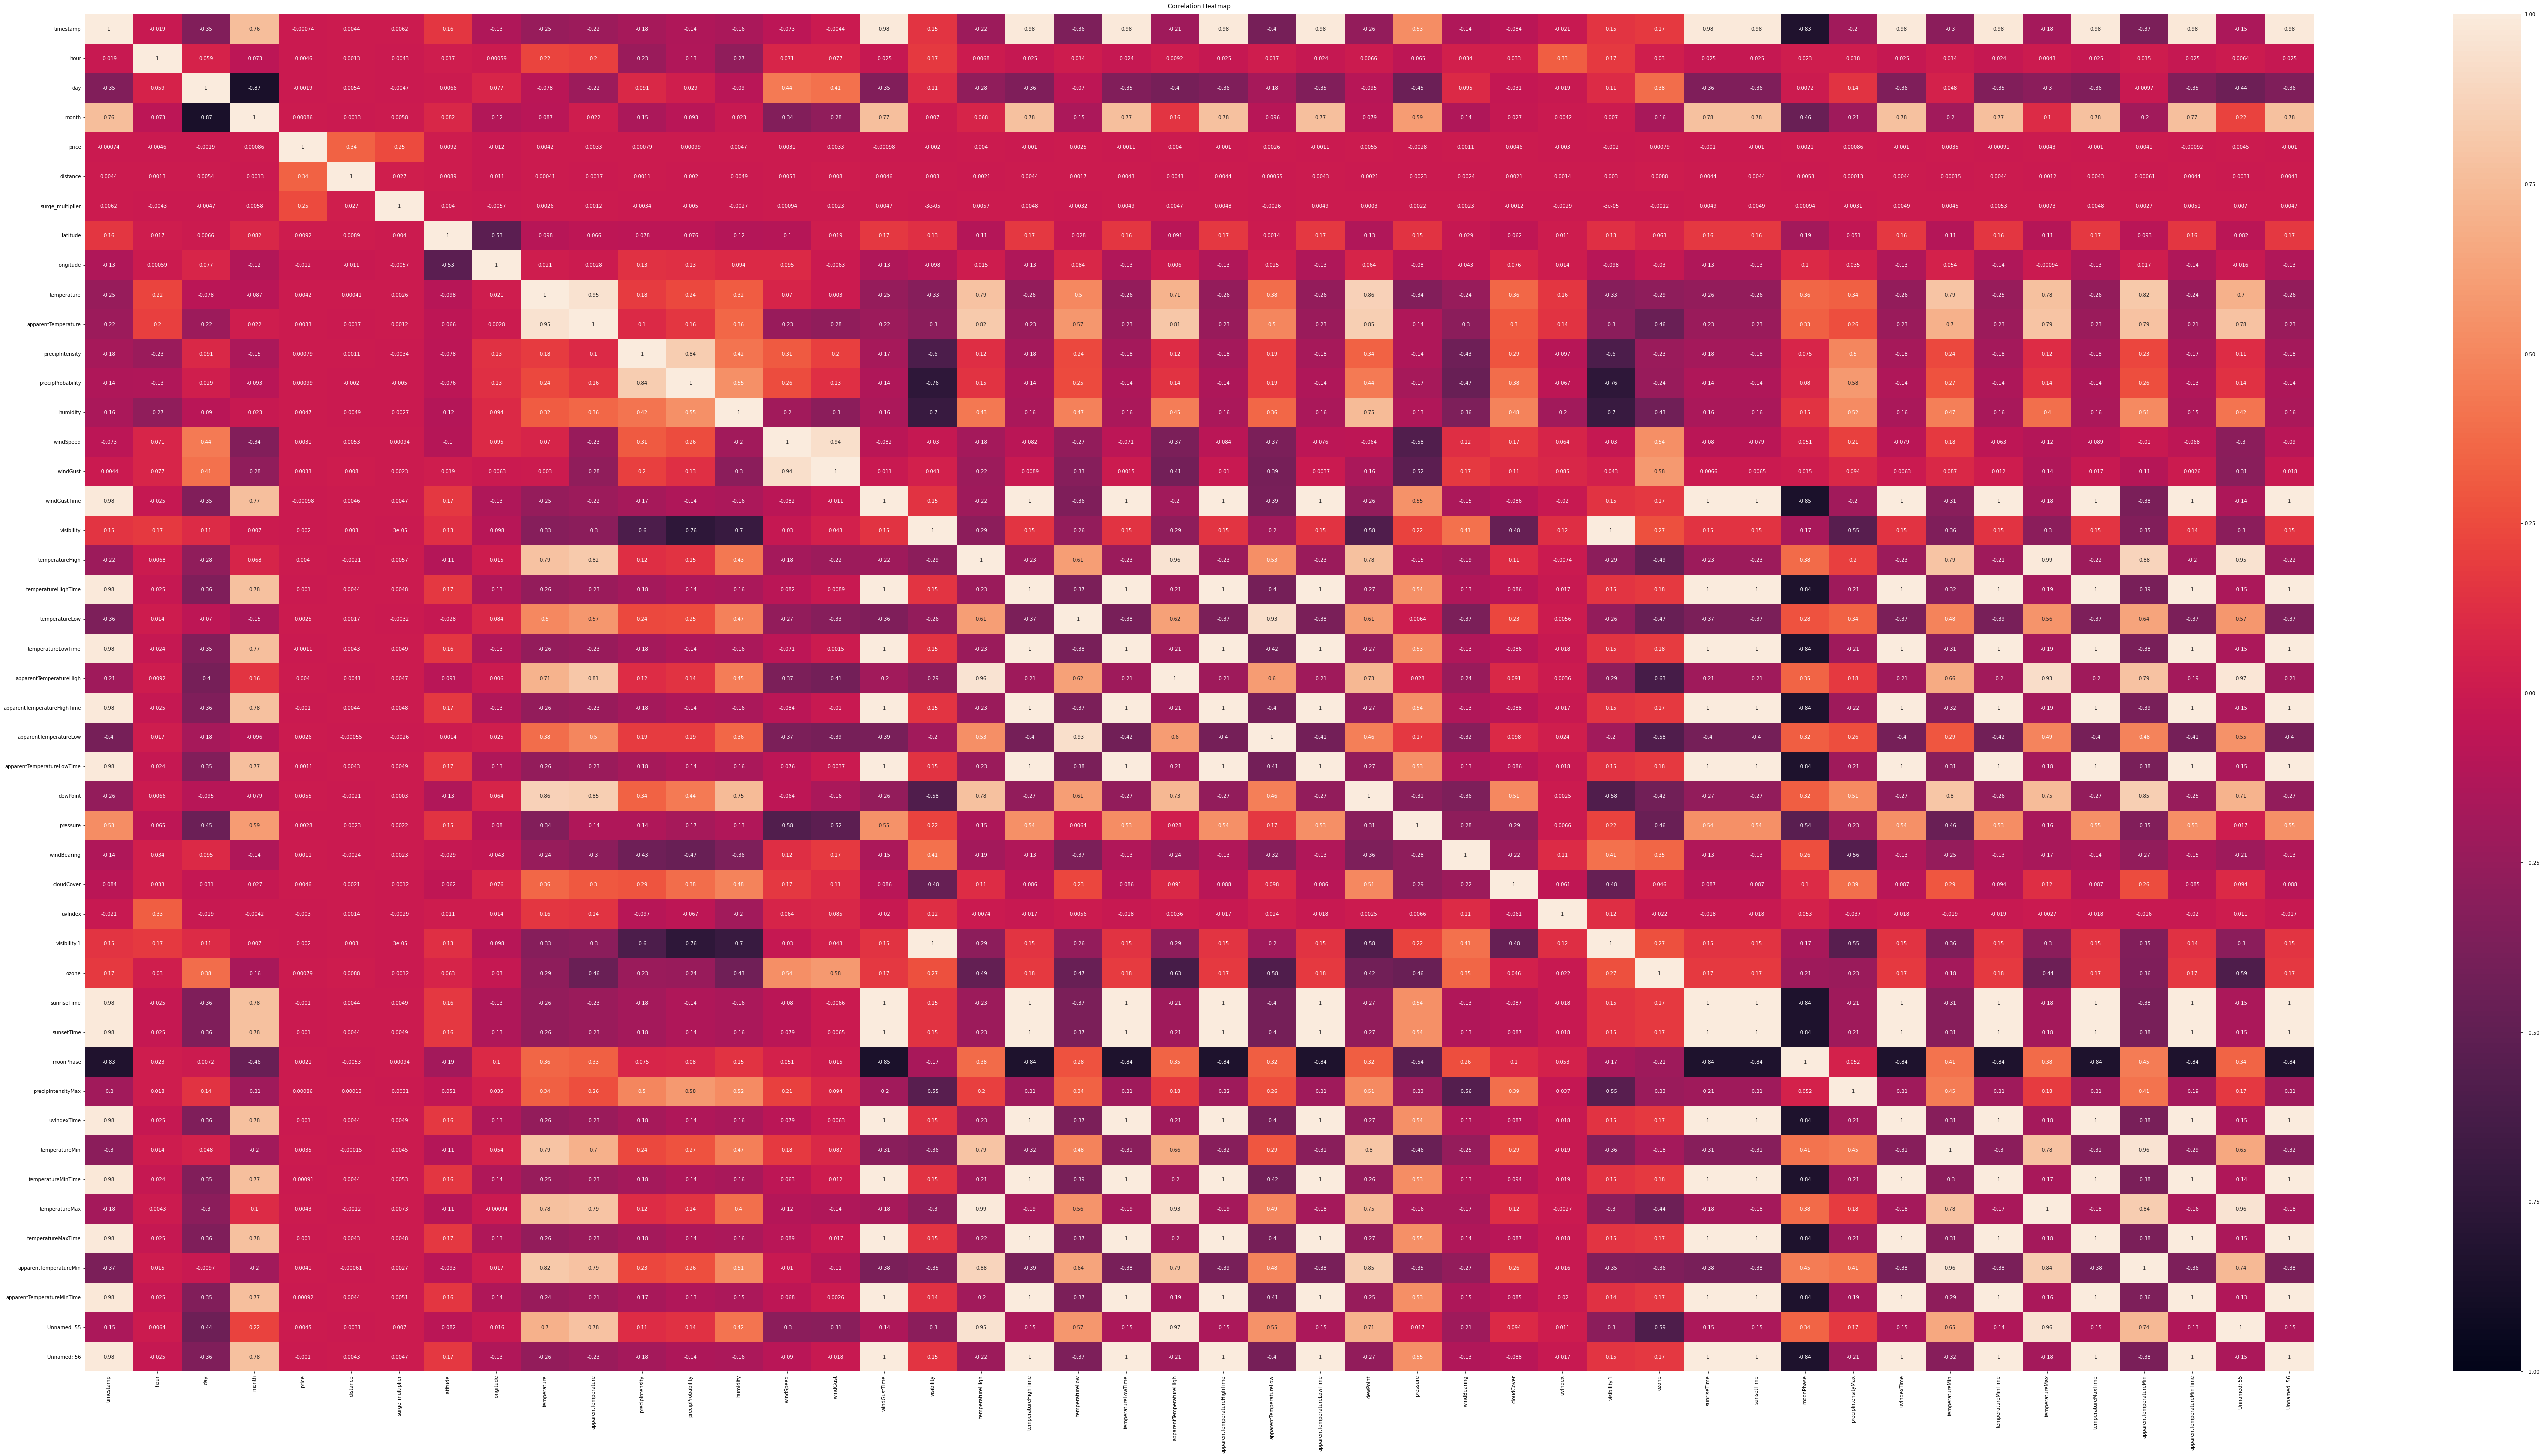

In [44]:
plt.figure(figsize=(100, 50))
heatmap = sns.heatmap(pandas_df.corr(), vmin=-1, vmax=1, annot=True)
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

# Splitting Training and Test data

In [45]:
from sklearn.model_selection import  train_test_split

X = pandas_df[ ['hour','day','month','distance','surge_multiplier','latitude','longitude','humidity','apparentTemperature','precipIntensity','precipProbability',
                        "temperature" ,'windSpeed','windGust','visibility','temperatureHigh','temperatureLow','apparentTemperatureHigh','apparentTemperatureLow','dewPoint','pressure','windBearing','cloudCover','uvIndex'
                         ,'visibility.1','ozone','moonPhase','precipIntensityMax','temperatureMin','apparentTemperatureMin']].replace(',', '', regex = True).astype(float)

y = pandas_df['price']

#Spliting data into Training set, Validation set and Test set 20%

X_t, X_test, y_t, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_t, y_t, test_size=0.15, random_state=1)

This code plots the distribution of predictor variables from the test, validation, and training sets using histograms 

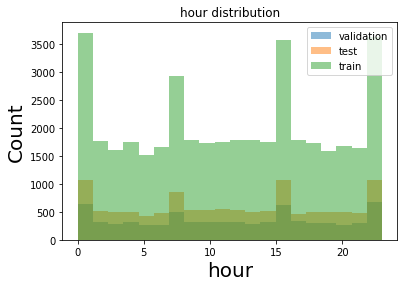

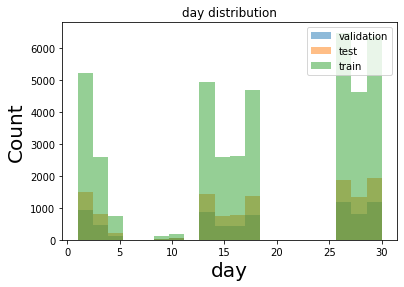

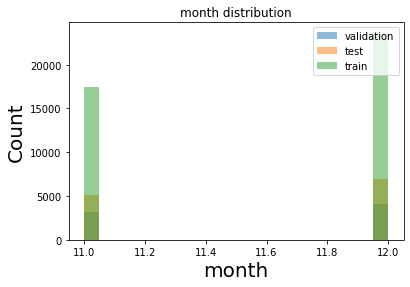

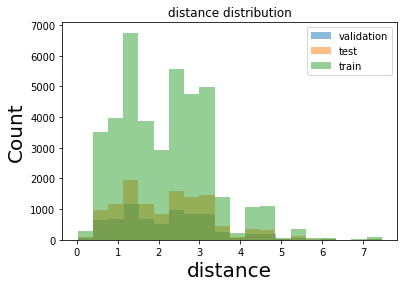

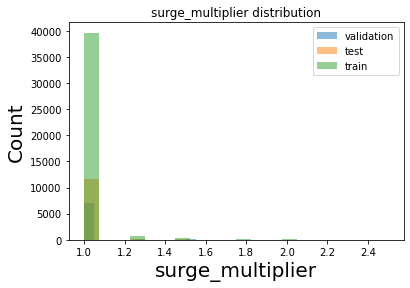

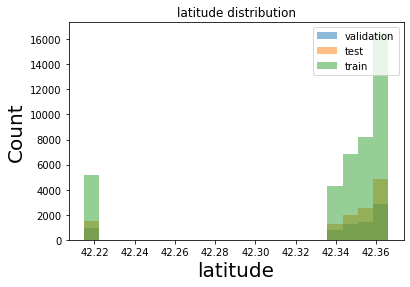

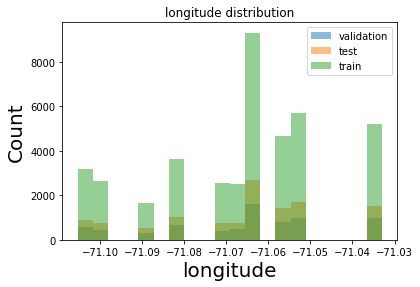

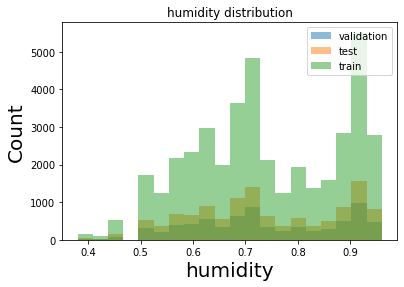

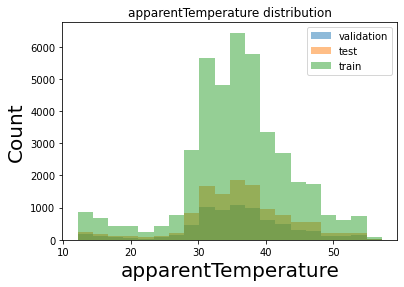

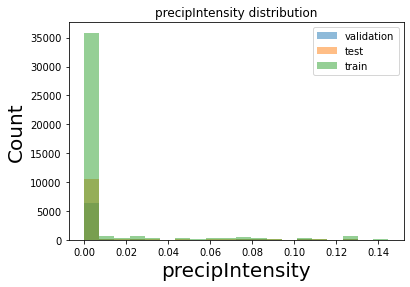

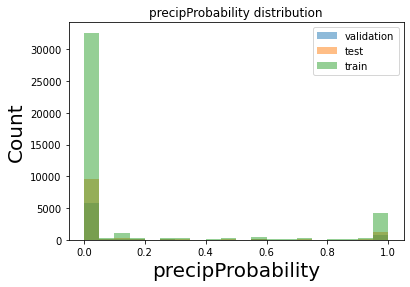

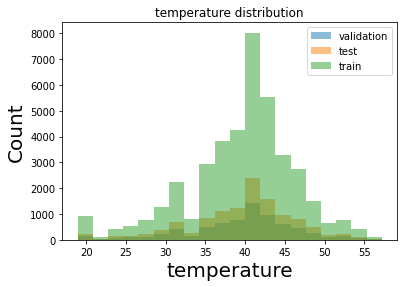

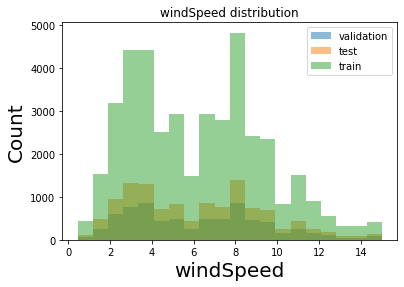

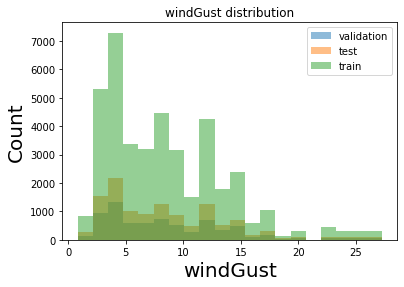

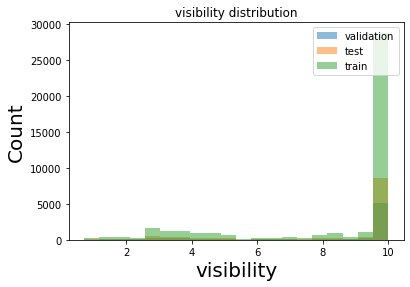

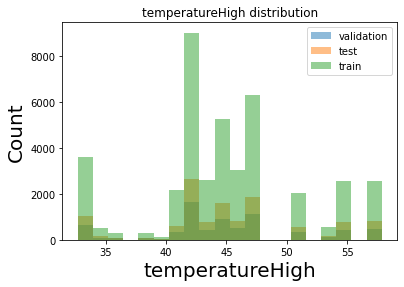

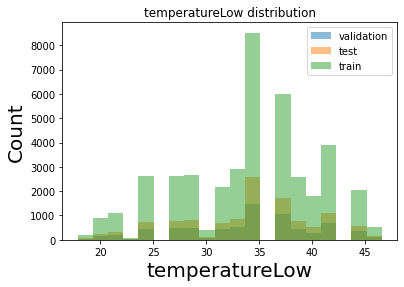

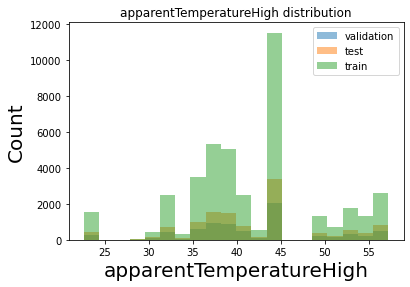

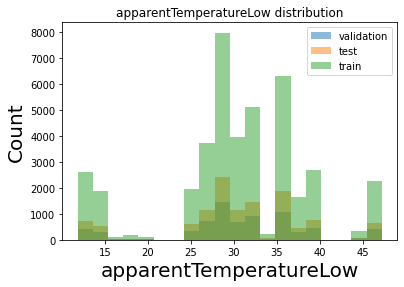

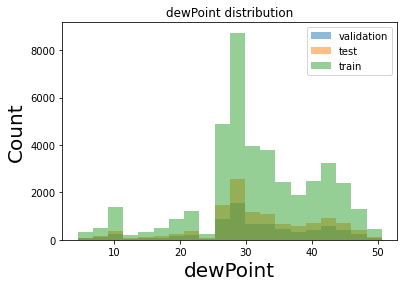

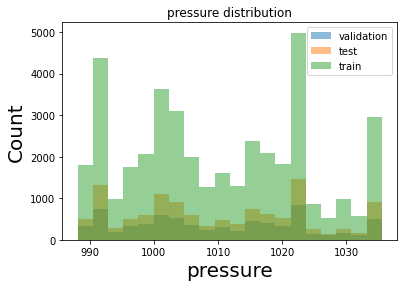

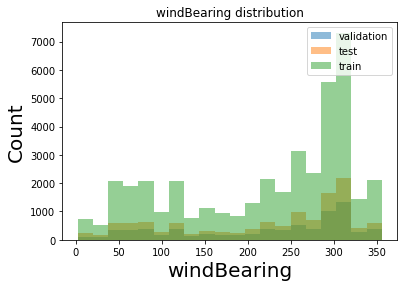

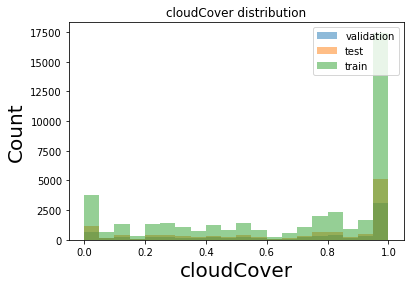

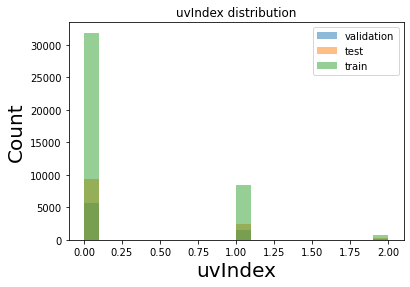

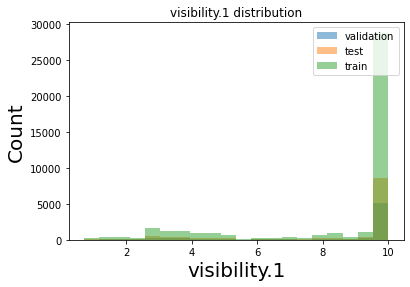

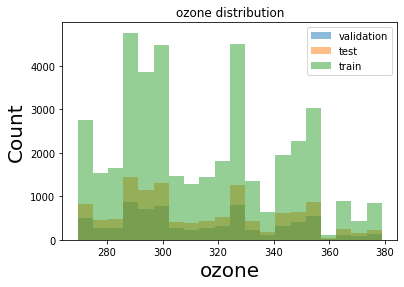

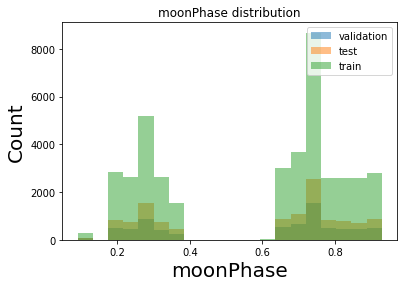

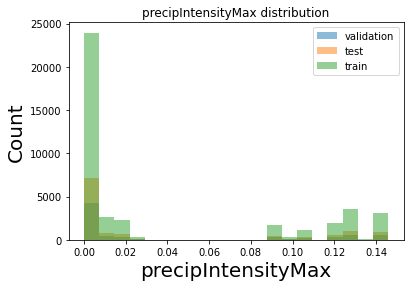

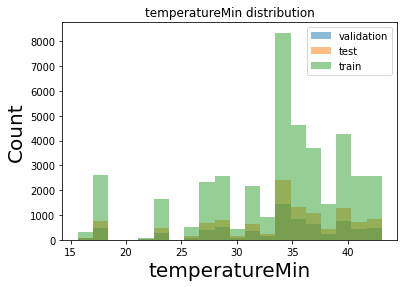

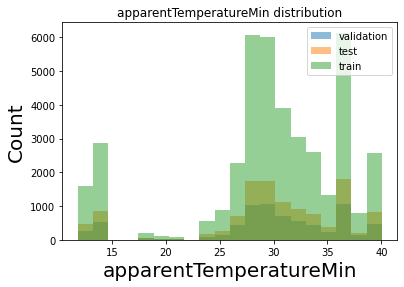

In [46]:
# Looking the data for test, training and validation set
X_test_plot = X_test[['hour','day','month','distance','surge_multiplier','latitude','longitude','humidity','apparentTemperature','precipIntensity','precipProbability',
                        "temperature" ,'windSpeed','windGust','visibility','temperatureHigh','temperatureLow','apparentTemperatureHigh','apparentTemperatureLow','dewPoint','pressure','windBearing','cloudCover','uvIndex'
                         ,'visibility.1','ozone','moonPhase','precipIntensityMax','temperatureMin','apparentTemperatureMin']]

X_val_plot = X_val[['hour','day','month','distance','surge_multiplier','latitude','longitude','humidity','apparentTemperature','precipIntensity','precipProbability',
                        "temperature" ,'windSpeed','windGust','visibility','temperatureHigh','temperatureLow','apparentTemperatureHigh','apparentTemperatureLow','dewPoint','pressure','windBearing','cloudCover','uvIndex'
                         ,'visibility.1','ozone','moonPhase','precipIntensityMax','temperatureMin','apparentTemperatureMin']]

X_train_plot = X_train[['hour','day','month','distance','surge_multiplier','latitude','longitude','humidity','apparentTemperature','precipIntensity','precipProbability',
                        "temperature" ,'windSpeed','windGust','visibility','temperatureHigh','temperatureLow','apparentTemperatureHigh','apparentTemperatureLow','dewPoint','pressure','windBearing','cloudCover','uvIndex'
                         ,'visibility.1','ozone','moonPhase','precipIntensityMax','temperatureMin','apparentTemperatureMin']]

# Plotting the data to see the histogram
import matplotlib.pyplot as plt
for c in X_test_plot.columns:
  fig, ax = plt.subplots(figsize=(6,4))
  ax.hist(X_val_plot[c], bins=20, alpha=0.5, label="validation")
  ax.hist(X_test_plot[c], bins=20, alpha=0.5, label="test")
  ax.hist(X_train_plot[c], bins=20, alpha=0.5, label="train")
  ax.set_xlabel(c, size=20)
  ax.set_ylabel("Count", size=20)
  ax.legend(loc='upper right')
  ax.set_title("{} distribution".format(c))
  plt.show()

In [47]:
# set this to True if interactive (matplotlib) plots are desired
interactive = True
if not interactive: matplotlib.use('Agg', warn=False)
import matplotlib.pyplot as plt

# From here on we start using H20 automl


In [48]:
data = h2o.import_file( '/content/drive/MyDrive/uber_lyft.csv' )

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [49]:
data.describe()

Rows:60392
Cols:57

id                                    timestamp           hour                day                 month                datetime        timezone          source            destination              cab_type    product_id    name          price               distance            surge_multiplier    latitude             longitude             temperature         apparentTemperature    short_summary    long_summary                                        precipIntensity       precipProbability    humidity             windSpeed           windGust           windGustTime        visibility         temperatureHigh    temperatureHighTime    temperatureLow     temperatureLowTime    apparentTemperatureHigh    apparentTemperatureHighTime    apparentTemperatureLow    apparentTemperatureLowTime    icon                 dewPoint           pressure            windBearing         cloudCover          uvIndex              visibility.1       ozone               sunriseTime         sunsetTime         moonPhase            precipIntensityMax    uvIndexTime         temperatureMin      temperatureMinTime    temperatureMax      temperatureMaxTime    apparentTemperatureMin    apparentTemperatureMinTime    C56                 C57
-------  ------------------------------------  ------------------  ------------------  ------------------  -------------------  --------------  ----------------  ----------------  -----------------------  ----------  ------------  ------------  ------------------  ------------------  ------------------  -------------------  --------------------  ------------------  ---------------------  ---------------  --------------------------------------------------  --------------------  -------------------  -------------------  ------------------  -----------------  ------------------  -----------------  -----------------  ---------------------  -----------------  --------------------  -------------------------  -----------------------------  ------------------------  ----------------------------  -------------------  -----------------  ------------------  ------------------  ------------------  -------------------  -----------------  ------------------  ------------------  -----------------  -------------------  --------------------  ------------------  ------------------  --------------------  ------------------  --------------------  ------------------------  ----------------------------  ------------------  ------------------
type     uuid                                  int                 int                 int                 int                  enum            enum              enum              enum                     enum        enum          enum          real                real                real                real                 real                  real                real                   enum             enum                                                real                  real                 real                 real                real               int                 real               real               int                    real               int                   real                       int                            real                      int                           enum                 real               real                int                 real                int                  real               real                int                 int                real                 real                  int                 real                int                   real                int                   real                      int                           real                int
mins     NaN                                   1543203646.0        0.0                 1.0                 11.0                                                                                                                                      2.5                 0.02                1.0                 42.2148       

Function to plot a scatterplot

In [50]:
def scatter_plot(data, x, y, max_points = 5000, fit = True):
    if(fit):
        lr = H2OGeneralizedLinearEstimator(family = "gaussian")
        lr.train(x=x, y=y, training_frame=data)
        coeff = lr.coef()
    df = data[[x,y]]
    runif = df[y].runif()
    df_subset = df[runif < float(max_points)/data.nrow]
    df_py = h2o.as_list(df_subset)
    
    if(fit): h2o.remove(lr._id)

    # If x variable is string, generate box-and-whisker plot
    if(df_py[x].dtype == "object"):
        if interactive: df_py.boxplot(column = y, by = x)
    # Otherwise, generate a scatter plot
    else:
        if interactive: df_py.plot(x = x, y = y, kind = "scatter")
    
    if(fit):
        x_min = min(df_py[x])
        x_max = max(df_py[x])
        y_min = coeff["Intercept"] + coeff[x]*x_min
        y_max = coeff["Intercept"] + coeff[x]*x_max
        plt.plot([x_min, x_max], [y_min, y_max], "k-")
    if interactive: plt.show()

glm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


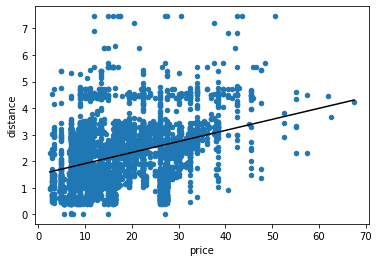

In [51]:
scatter_plot(data, "price", "distance", max_points = 5000,fit = True)

Splitting the data into training and test sets

In [52]:
df =  data[['hour','day','month','distance','price','surge_multiplier','latitude','longitude','humidity','apparentTemperature','precipIntensity','precipProbability',
                        "temperature" ,'windSpeed','windGust','visibility','temperatureHigh','temperatureLow','apparentTemperatureHigh','apparentTemperatureLow','dewPoint','pressure','windBearing','cloudCover','uvIndex'
                         ,'visibility.1','ozone','moonPhase','precipIntensityMax','temperatureMin','apparentTemperatureMin']]

In [53]:
train, test = df.split_frame(ratios=[0.8], seed = 1)

In [54]:
myY = 'price'
myX = ['hour','day','month','distance','surge_multiplier','latitude','longitude','humidity','apparentTemperature','precipIntensity','precipProbability',
                        "temperature" ,'windSpeed','windGust','visibility','temperatureHigh','temperatureLow','apparentTemperatureHigh','apparentTemperatureLow','dewPoint','pressure','windBearing','cloudCover','uvIndex'
                         ,'visibility.1','ozone','moonPhase','precipIntensityMax','temperatureMin','apparentTemperatureMin']

2) Does the model make sense?

This block of code calculates the magnitude of the normalized coefficients for each predictor in the GLM model, and then takes the absolute value of the coefficients to ensure that the magnitudes are positive. The resulting coefficients are then sorted in descending order based on their magnitudes.

The tabulate function from the tabulate package is then used to format the sorted coefficients as a table, with headers for the predictor names and the normalized coefficients.

The resulting table is then printed to the console, showing the variable importances for the GLM model.

In [55]:
# Build simple GLM model
data_glm = H2OGeneralizedLinearEstimator(family="gaussian", standardize=True)
data_glm.train(x               =myX,
               y               =myY,
               training_frame  =train,
               validation_frame=test)

glm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OGeneralizedLinearEstimator : Generalized Linear Modeling
Model Key: GLM_model_python_1677613694743_2


GLM Model: summary
    family    link      regularization                                 number_of_predictors_total    number_of_active_predictors    number_of_iterations    training_frame
--  --------  --------  ---------------------------------------------  ----------------------------  -----------------------------  ----------------------  ----------------
    gaussian  identity  Elastic Net (alpha = 0.5, lambda = 0.006371 )  30                            22                             1                       py_16_sid_a3b5

ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 71.622714588386
RMSE: 8.463020417580594
MAE: 6.936662858021601
RMSLE: 0.4990263733641547
Mean Residual Deviance: 71.622714588386
R^2: 0.17534369876427802
Null degrees of freedom: 48317
Residual degrees of freedom: 48295
Null deviance: 4196495.3378710095
Residual deviance: 3460666.323481635
AIC: 343554.64198801044

ModelMetricsRegressionGLM: glm
** Reported on validation data. **

MSE: 72.67014345226852
RMSE: 8.524678495536856
MAE: 6.986767098515142
RMSLE: 0.5021973674660224
Mean Residual Deviance: 72.67014345226852
R^2: 0.17655344858971056
Null degrees of freedom: 12073
Residual degrees of freedom: 12051
Null deviance: 1065571.9745032007
Residual deviance: 877419.3120426901
AIC: 86060.8539894045

Scoring History: 
    timestamp            duration    iterations    negative_log_likelihood    objective          training_rmse      training_deviance    training_mae       training_r2          validation_rmse    validation_deviance    validation_mae     validation_r2
--  -------------------  ----------  ------------  -------------------------  -----------------  -----------------  -------------------  -----------------  -------------------  -----------------  ---------------------  -----------------  -------------------
    2023-02-28 19:49:31  0.000 sec   0             4196495.3378710095         86.85159439279377
    2023-02-28 19:49:31  0.593 sec   1                                                           8.463020417580594  71.622714588386      6.936662858021601  0.17534369876427802  8.524678495536856  72.67014345226852      6.986767098515142  0.17655344858971056

Variable Importances: 
variable                relative_importance    scaled_importance      percentage
----------------------  ---------------------  ---------------------  ---------------------
distance                3.114530086517334      1.0                    0.48462418101048405
surge_multiplier        2.2383482456207275     0.7186792817672368     0.34828935833565006
windSpeed               0.15233731269836426    0.04891181284708916    0.023703847242758657
day                     0.13359086215496063    0.042892782681172255   0.020786879678123777
month                   0.12928402423858643    0.04150996158240736    0.020116731135650826
humidity                0.07665490359067917    0.024612028608269006   0.01192758420728897
windGust                0.07491712272167206    0.02405406935896527    0.011657183663057923
precipIntensityMax      0.04874837398529053    0.01565191943282877    0.007585298636376722
latitude                0.0480777733027935     0.015436605833708303   0.007480952459742546
longitude               0.04771389067173004    0.015319771954774625   0.007424331936850035
---                     ---                    ---                    ---
temperatureLow          0.020025204867124557   0.006429607135218505   0.0031159430921244326
temperatureHigh         0.008155529387295246   0.0026185424962180265  0.0012690090126708097
temperature             0.0                    0.0                    0.0
visibility              0.0                    0.0                    0.0
apparentTemperatureLow  0.0                    0.0                    0.0
windBearing             0.0                    0.0                    0.0
cloudCover        

Building a simple GBM model

This block of code fits a GBM model to the training data and evaluates its performance using the validation data. The data_gbm object can be used to make predictions on new data or to further tune the model hyperparameters.

In [56]:
# Build simple GBM model

data_gbm = H2OGradientBoostingEstimator(balance_classes=True,
                                        ntrees         =10,
                                        max_depth      =1,
                                        learn_rate     =0.1,
                                        min_rows       =2)

data_gbm.train(x               =myX,
               y               =myY,
               training_frame  =train,
               validation_frame=test)

gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OGradientBoostingEstimator : Gradient Boosting Machine
Model Key: GBM_model_python_1677613694743_3


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    10                 10                          830                    1            1            1             2             2             2

ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 78.69870310588591
RMSE: 8.871228951271966
MAE: 7.255840089414988
RMSLE: 0.5203452384866427
Mean Residual Deviance: 78.69870310588591

ModelMetricsRegression: gbm
** Reported on validation data. **

MSE: 79.9596643392593
RMSE: 8.942016793724965
MAE: 7.289892648571461
RMSLE: 0.5239743992566812
Mean Residual Deviance: 79.9596643392593

Scoring History: 
    timestamp            duration    number_of_trees    training_rmse    training_mae    training_deviance    validation_rmse    validation_mae    validation_deviance
--  -------------------  ----------  -----------------  ---------------  --------------  -------------------  -----------------  ----------------  ---------------------
    2023-02-28 19:49:32  0.044 sec   0                  9.31942          7.55614         86.8516              9.39433            7.58365           88.2534
    2023-02-28 19:49:33  0.950 sec   1                  9.24838          7.50706         85.5325              9.32092            7.53206           86.8795
    2023-02-28 19:49:33  1.249 sec   2                  9.1881           7.46677         84.4212              9.25933            7.49225           85.7353
    2023-02-28 19:49:33  1.542 sec   3                  9.13597          7.42763         83.4659              9.20405            7.44932           84.7145
    2023-02-28 19:49:33  1.754 sec   4                  9.08926          7.40122         82.6147              9.16002            7.42727           83.906
    2023-02-28 19:49:34  1.919 sec   5                  9.04532          7.37167         81.8179              9.11501            7.39854           83.0834
    2023-02-28 19:49:34  2.075 sec   6                  9.00603          7.33956         81.1086              9.07448            7.36542           82.3461
    2023-02-28 19:49:34  2.238 sec   7                  8.96808          7.31807         80.4265              9.039              7.34759           81.7035
    2023-02-28 19:49:34  2.391 sec   8                  8.93458          7.29987         79.8267              9.00427            7.33066           81.0768
    2023-02-28 19:49:34  2.543 sec   9                  8.90164          7.28248         79.2391              8.97355            7.31743           80.5245
    2023-02-28 19:49:34  2.700 sec   10                 8.87123          7.25584         78.6987              8.94202            7.28989           79.9597

Variable Importances: 
variable                relative_importance    scaled_importance    percentage
----------------------  ---------------------  -------------------  -----------------
distance                1533949.625            1.0                  0.739850884885472
surge_multiplier        539373.0625            0.35162371287127503  0.260149115114528
hour                    0.0                    0.0                  0.0
day                     0.0                    0.0                  0.0
month                   0.0                    0.0                  0.0
latitude                0.0                    0.0                  0.0
longitude               0.0                    0.0                  0.0
humidity                0.0                    0.0                  0.0
apparentTemperature     0.0                    0.0                  0.0
precipIntensity         0.0                    0.0                  0.0
--- 

This code trains an H2O AutoML model using the H2OAutoML() function with a maximum of 10 models specified by max_models=10. The AutoML model is trained using the predictor variables myX and the response variable myY from the H2OFrame object data. The seed parameter is set to 1, which ensures that the results can be reproduced.

After the AutoML model is trained, the variable importance scores are obtained using the varimp() method of the best performing model, which is accessed using the leader attribute of the H2OAutoML object aml.  However from this method, variable importance is not obtained, therefore we use other methods to find variable importance


In [57]:
# run AutoML for 10 models
aml = H2OAutoML(max_models=10, seed=1)
aml.train(x=myX,y=myY, training_frame=data)

# get variable importance scores
var_imp = aml.leader.varimp()

# print the variable importance scores
print(var_imp)

AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
None


This block of code compute and display the variable importances for the GLM model, which can be used to gain insight into the most important predictors for the target variable.

In [58]:
# Variable importances from each algorithm
# Calculate magnitude of normalized GLM coefficients
from six import iteritems
glm_varimp = data_glm.coef_norm()
for k,v in iteritems(glm_varimp):
    glm_varimp[k] = abs(glm_varimp[k])
    
# Sort in descending order by magnitude
glm_sorted = sorted(glm_varimp.items(), key = operator.itemgetter(1), reverse = True)
table = tabulate(glm_sorted, headers = ["Predictor", "Normalized Coefficient"], tablefmt = "orgtbl")
print("Variable Importances:\n\n" + table)

data_glm.varimp()

Variable Importances:

| Predictor               |   Normalized Coefficient |
|-------------------------+--------------------------|
| Intercept               |              16.5678     |
| distance                |               3.11453    |
| surge_multiplier        |               2.23835    |
| windSpeed               |               0.152337   |
| day                     |               0.133591   |
| month                   |               0.129284   |
| humidity                |               0.0766549  |
| windGust                |               0.0749171  |
| precipIntensityMax      |               0.0487484  |
| latitude                |               0.0480778  |
| longitude               |               0.0477139  |
| precipProbability       |               0.0430716  |
| pressure                |               0.0394984  |
| uvIndex                 |               0.0369486  |
| apparentTemperature     |               0.0342142  |
| temperatureMin          |               

[('distance', 3.114530086517334, 1.0, 0.48462418101048405),
 ('surge_multiplier',
  2.2383482456207275,
  0.7186792817672368,
  0.34828935833565006),
 ('windSpeed', 0.15233731269836426, 0.04891181284708916, 0.023703847242758657),
 ('day', 0.13359086215496063, 0.042892782681172255, 0.020786879678123777),
 ('month', 0.12928402423858643, 0.04150996158240736, 0.020116731135650826),
 ('humidity', 0.07665490359067917, 0.024612028608269006, 0.01192758420728897),
 ('windGust', 0.07491712272167206, 0.02405406935896527, 0.011657183663057923),
 ('precipIntensityMax',
  0.04874837398529053,
  0.01565191943282877,
  0.007585298636376722),
 ('latitude', 0.0480777733027935, 0.015436605833708303, 0.007480952459742546),
 ('longitude',
  0.04771389067173004,
  0.015319771954774625,
  0.007424331936850035),
 ('precipProbability',
  0.04307163134217262,
  0.013829255183190508,
  0.0067019914671386915),
 ('pressure', 0.03949841111898422, 0.012681980915827763, 0.006145994614923618),
 ('uvIndex', 0.036948595

3) Does regularization help?

The difference in r^2 score is miniscule but lasso regularization performs better. But, there is little to no change in the performance and the model is performing badly even after applying regularization.

This block of code is creating several H2OGeneralizedLinearEstimator objects, which are models for performing generalized linear regression in H2O.

The price_glm object is using Elastic Net regularization with a Gaussian family and a lambda of 0.0001, and is also computing p-values for the coefficients. nfolds is set to 5 to perform cross-validation during model training, and remove_collinear_columns is set to True to automatically remove collinear columns.

The price_glm_regularization_ridge object is using Ridge regularization with a Gaussian family, with alpha set to 0 to indicate that only Ridge regularization should be used. nfolds is set to 5 for cross-validation, and remove_collinear_columns is set to True.

The price_glm_regularization_lasso object is using Lasso regularization with a Gaussian family, with alpha set to 1 to indicate that only Lasso regularization should be used. nfolds is set to 5 for cross-validation, and remove_collinear_columns is set to True.

The price_glm_regularization_lambda_search object is using a lambda search to automatically select the optimal regularization strength, and remove_collinear_columns is set to True.

In [59]:
# Model performance of GBM model on test data
data_gbm.model_performance(test)

ModelMetricsRegression: gbm
** Reported on test data. **

MSE: 79.9596643392593
RMSE: 8.942016793724965
MAE: 7.289892648571461
RMSLE: 0.5239743992566812
Mean Residual Deviance: 79.9596643392593

In [60]:
# Model performance of GLM model on test data
data_glm.model_performance(test)

ModelMetricsRegressionGLM: glm
** Reported on test data. **

MSE: 72.67014345226852
RMSE: 8.524678495536856
MAE: 6.986767098515142
RMSLE: 0.5021973674660224
Mean Residual Deviance: 72.67014345226852
R^2: 0.17655344858971056
Null degrees of freedom: 12073
Residual degrees of freedom: 12051
Null deviance: 1065571.9745032007
Residual deviance: 877419.3120426901
AIC: 86060.8539894045

In [61]:
from h2o.estimators.glm import H2OGeneralizedLinearEstimator

price_glm = H2OGeneralizedLinearEstimator(
    family="gaussian", lambda_=0.0001, compute_p_values=True, nfolds=5, remove_collinear_columns = True
)  # Elastic Net Regularization
price_glm_regularization_ridge = H2OGeneralizedLinearEstimator(
    family="gaussian", alpha=0, nfolds=5, remove_collinear_columns = True
)  # RIDGE Regularization
price_glm_regularization_lasso = H2OGeneralizedLinearEstimator(
    family="gaussian", alpha=1, nfolds=5, remove_collinear_columns = True
)  # LASSO Regularization
price_glm_regularization_lambda_search = H2OGeneralizedLinearEstimator(
    lambda_search=True, remove_collinear_columns = True
)  # Lambda Search

In [62]:
price_glm.train(x=myX, y=myY, training_frame=df)

glm Model Build progress: |

/usr/local/lib/python3.8/dist-packages/h2o/estimators/estimator_base.py:193: RuntimeWarning: remove_collinear_columns should only be used with no regularization, i.e. lambda=0.0.  It is used improperly here.  Please set lambda=0.
  warnings.warn(mesg["message"], RuntimeWarning)


██████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OGeneralizedLinearEstimator : Generalized Linear Modeling
Model Key: GLM_model_python_1677613694743_16


GLM Model: summary
    family    link      regularization                               number_of_predictors_total    number_of_active_predictors    number_of_iterations    training_frame
--  --------  --------  -------------------------------------------  ----------------------------  -----------------------------  ----------------------  ----------------
    gaussian  identity  Elastic Net (alpha = 0.5, lambda = 1.0E-4 )  30                            29                             1                       py_14_sid_a3b5

ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 71.81903054178052
RMSE: 8.474610937487368
MAE: 6.942641585234186
RMSLE: 0.4994273598487362
Mean Residual Deviance: 71.81903054178052
R^2: 0.17574232922308164
Null degrees of freedom: 60391
Residual degrees of freedom: 60362
Null deviance: 5262061.908857858
Residual deviance: 4337294.892479209
AIC: 429571.5078105702

ModelMetricsRegressionGLM: glm
** Reported on cross-validation data. **

MSE: 71.89624791040688
RMSE: 8.479165519696314
MAE: 6.94634968394637
RMSLE: 0.4996971612194484
Mean Residual Deviance: 71.89624791040688
R^2: 0.17485611552836378
Null degrees of freedom: 60391
Residual degrees of freedom: 60362
Null deviance: 5262238.331795581
Residual deviance: 4341958.203805293
AIC: 429636.40434523305

Cross-Validation Metrics Summary: 
                        mean         sd          cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid
----------------------  -----------  ----------  ------------  ------------  ------------  ------------  ------------
mae                     6.94637      0.0658653   6.91505       7.00086       7.03241       6.88742       6.89613
mean_residual_deviance  71.8977      1.21086     71.6019       72.3377       73.7673       70.7162       71.0656
mse                     71.8977      1.21086     71.6019       72.3377       73.7673       70.7162       71.0656
null_deviance           1.05245e+06  13929.5     1.03471e+06   1.06198e+06   1.07005e+06   1.05063e+06   1.04486e+06
r2                      0.174828     0.00576392  0.174512      0.174755      0.168236      0.184018      0.17262
residual_deviance       868392       14734.2     854140        876371        889855        857222        864371
rmse                    8.47901      0.071221    8.46179       8.50516       8.58879       8.40929       8.43004
rmsle                   0.499681     0.00312497  0.496386      0.500822      0.503331      0.496437      0.50143

Scoring History: 
    timestamp            duration    iterations    negative_log_likelihood    objective          training_rmse      training_deviance    training_mae       training_r2
--  -------------------  ----------  ------------  -------------------------  -----------------  -----------------  -------------------  -----------------  -------------------
    2023-02-28 20:03:43  0.000 sec   0             5262061.908857858          87.13177091101235
    2023-02-28 20:03:43  0.545 sec   1                                                           8.474610937487368  71.81903054178052    6.942641585234186  0.17574232922308164

Variable Importances: 
variable                 relative_importance    scaled_importance      percentage
-----------------------  ---------------------  ---------------------  ---------------------
distance                 3.1463139057159424     1.0                    0.3380859388178712
surge_multiplier         2.2389469146728516     0.7116095156955994     0.24058517118567738
temperatureHigh          0.4652548134326935     0.14787298005690405    0.049993775288334756
apparentTemperature      0.4626414179801941     0.1470423587232375     0.049712953894939946
windSpeed                0.3883834779262543     0.12344079121306803    0.041733595785690934
apparentTemperatureHigh  0.36021578311920166    0.11448818964464855    0.038706847079569

## Ridge Regularization

In [63]:
price_glm_regularization_ridge.train(x=myX, y=myY, training_frame=df)

glm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OGeneralizedLinearEstimator : Generalized Linear Modeling
Model Key: GLM_model_python_1677613694743_17


GLM Model: summary
    family    link      regularization               number_of_predictors_total    number_of_active_predictors    number_of_iterations    training_frame
--  --------  --------  ---------------------------  ----------------------------  -----------------------------  ----------------------  ----------------
    gaussian  identity  Ridge ( lambda = 0.003205 )  30                            29                             1                       py_14_sid_a3b5

ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 71.81903054178052
RMSE: 8.474610937487368
MAE: 6.942641585234186
RMSLE: 0.4994273598487362
Mean Residual Deviance: 71.81903054178052
R^2: 0.17574232922308164
Null degrees of freedom: 60391
Residual degrees of freedom: 60362
Null deviance: 5262061.908857858
Residual deviance: 4337294.892479209
AIC: 429571.5078105702

ModelMetricsRegressionGLM: glm
** Reported on cross-validation data. **

MSE: 71.91472689933117
RMSE: 8.48025511994369
MAE: 6.9469959311782175
RMSLE: 0.49973112277613196
Mean Residual Deviance: 71.91472689933117
R^2: 0.17464403457636335
Null degrees of freedom: 60391
Residual degrees of freedom: 60362
Null deviance: 5262388.712053525
Residual deviance: 4343074.186904408
AIC: 429651.9244834802

Cross-Validation Metrics Summary: 
                        mean         sd          cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid
----------------------  -----------  ----------  ------------  ------------  ------------  ------------  ------------
mae                     6.94724      0.0409871   6.90169       6.97727       6.96089       6.99033       6.906
mean_residual_deviance  71.9193      0.907047    70.926        72.9651       71.9723       72.642        71.0914
mse                     71.9193      0.907047    70.926        72.9651       71.9723       72.642        71.0914
null_deviance           1.05248e+06  21248.5     1.02053e+06   1.07337e+06   1.0596e+06    1.06649e+06   1.0424e+06
r2                      0.174375     0.0117642   0.158804      0.180301      0.181234      0.186377      0.16516
residual_deviance       868615       7612        858134        879448        867554        867709        870229
rmse                    8.48039      0.0534809   8.42176       8.54196       8.48365       8.52303       8.43157
rmsle                   0.499742     0.00286804  0.501504      0.499841      0.500601      0.501943      0.494822

Scoring History: 
    timestamp            duration    iterations    negative_log_likelihood    objective          training_rmse      training_deviance    training_mae       training_r2
--  -------------------  ----------  ------------  -------------------------  -----------------  -----------------  -------------------  -----------------  -------------------
    2023-02-28 20:03:45  0.000 sec   0             5262061.908857858          87.13177091101235
    2023-02-28 20:03:45  0.247 sec   1                                                           8.474610937487368  71.81903054178052    6.942641585234186  0.17574232922308164

Variable Importances: 
variable                 relative_importance    scaled_importance      percentage
-----------------------  ---------------------  ---------------------  ---------------------
distance                 3.1463139057159424     1.0                    0.3380859388178712
surge_multiplier         2.2389469146728516     0.7116095156955994     0.24058517118567738
temperatureHigh          0.4652548134326935     0.14787298005690405    0.049993775288334756
apparentTemperature      0.4626414179801941     0.1470423587232375     0.049712953894939946
windSpeed                0.3883834779262543     0.12344079121306803    0.041733595785690934
apparentTemperatureHigh  0.36021578311920166    0.11448818964464855    0.03870684707956948
humidity                 0.25000983476638794  

# Lasso Regularization

In [65]:
price_glm_regularization_lasso.train(x=myX, y=myY, training_frame=df)

glm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OGeneralizedLinearEstimator : Generalized Linear Modeling
Model Key: GLM_model_python_1677613694743_19


GLM Model: summary
    family    link      regularization              number_of_predictors_total    number_of_active_predictors    number_of_iterations    training_frame
--  --------  --------  --------------------------  ----------------------------  -----------------------------  ----------------------  ----------------
    gaussian  identity  Lasso (lambda = 0.003205 )  30                            29                             1                       py_14_sid_a3b5

ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 71.81903054178052
RMSE: 8.474610937487368
MAE: 6.942641585234186
RMSLE: 0.4994273598487362
Mean Residual Deviance: 71.81903054178052
R^2: 0.17574232922308164
Null degrees of freedom: 60391
Residual degrees of freedom: 60362
Null deviance: 5262061.908857858
Residual deviance: 4337294.892479209
AIC: 429571.5078105702

ModelMetricsRegressionGLM: glm
** Reported on cross-validation data. **

MSE: 71.91759959816589
RMSE: 8.480424493984124
MAE: 6.946795982872735
RMSLE: 0.49971320176812767
Mean Residual Deviance: 71.91759959816589
R^2: 0.17461106498553924
Null degrees of freedom: 60391
Residual degrees of freedom: 60362
Null deviance: 5262453.99071177
Residual deviance: 4343247.674932434
AIC: 429654.33684838144

Cross-Validation Metrics Summary: 
                        mean         sd          cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid
----------------------  -----------  ----------  ------------  ------------  ------------  ------------  ------------
mae                     6.94706      0.0686538   6.86091       6.94104       7.0449        6.97429       6.91416
mean_residual_deviance  71.9224      1.50653     69.932        72.0582       73.7421       72.8849       70.9948
mse                     71.9224      1.50653     69.932        72.0582       73.7421       72.8849       70.9948
null_deviance           1.05249e+06  19681.5     1.02176e+06   1.06351e+06   1.06566e+06   1.04374e+06   1.06778e+06
r2                      0.174446     0.0109993   0.175988      0.17119       0.174273      0.160075      0.190706
residual_deviance       868650       16687.1     841352        881344        879744        876659        864149
rmse                    8.48034      0.0888884   8.36253       8.48871       8.58732       8.53726       8.42584
rmsle                   0.499721     0.00284907  0.499041      0.498123      0.500692      0.504093      0.496656

Scoring History: 
    timestamp            duration    iterations    negative_log_likelihood    objective          training_rmse      training_deviance    training_mae       training_r2
--  -------------------  ----------  ------------  -------------------------  -----------------  -----------------  -------------------  -----------------  -------------------
    2023-02-28 20:04:39  0.000 sec   0             5262061.908857858          87.13177091101235
    2023-02-28 20:04:39  0.489 sec   1                                                           8.474610937487368  71.81903054178052    6.942641585234186  0.17574232922308164

Variable Importances: 
variable                 relative_importance    scaled_importance      percentage
-----------------------  ---------------------  ---------------------  ---------------------
distance                 3.1463139057159424     1.0                    0.3380859388178712
surge_multiplier         2.2389469146728516     0.7116095156955994     0.24058517118567738
temperatureHigh          0.4652548134326935     0.14787298005690405    0.049993775288334756
apparentTemperature      0.4626414179801941     0.1470423587232375     0.049712953894939946
windSpeed                0.3883834779262543     0.12344079121306803    0.041733595785690934
apparentTemperatureHigh  0.36021578311920166    0.11448818964464855    0.03870684707956948
humidity                 0.25000983476638794 

In [66]:
lambda_search = price_glm_regularization_lambda_search.train(
    x=myX, y=myY, training_frame=df
)

glm Model Build progress: |

/usr/local/lib/python3.8/dist-packages/h2o/estimators/estimator_base.py:193: RuntimeWarning: remove_collinear_columns should only be used with no regularization, i.e. lambda=0.0.  It is used improperly here with lambda_search.  Please disable lambda_search and set lambda=0.
  warnings.warn(mesg["message"], RuntimeWarning)


██████████████████████████████████████████████████████| (done) 100%


In [67]:
lambda_search

Model Details
=============
H2OGeneralizedLinearEstimator : Generalized Linear Modeling
Model Key: GLM_model_python_1677613694743_20


GLM Model: summary
    family    link      regularization                               lambda_search                                                               number_of_predictors_total    number_of_active_predictors    number_of_iterations    training_frame
--  --------  --------  -------------------------------------------  --------------------------------------------------------------------------  ----------------------------  -----------------------------  ----------------------  ----------------
    gaussian  identity  Elastic Net (alpha = 0.5, lambda = 4.8494 )  nlambda = 100, lambda.max = 6.4106, lambda.min = 4.8494, lambda.1se = -1.0  30                            2                              4                       py_14_sid_a3b5

ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 71.85032123097938
RMSE: 8.476456879556421
MAE: 6.944467441395037
RMSLE: 0.49953997181467263
Mean Residual Deviance: 71.85032123097938
R^2: 0.17538321005367086
Null degrees of freedom: 60391
Residual degrees of freedom: 60389
Null deviance: 5262061.908857858
Residual deviance: 4339184.599781306
AIC: 429543.81414951663

Scoring History: 
    timestamp            duration    iteration    lambda    predictors    deviance_train    alpha    iterations    training_rmse      training_deviance    training_mae       training_r2
--  -------------------  ----------  -----------  --------  ------------  ----------------  -------  ------------  -----------------  -------------------  -----------------  -------------------
    2023-02-28 20:04:44  0.000 sec   1            6.4       1             87.1318           0.5
    2023-02-28 20:04:44  0.056 sec   2            5.8       2             76.8577           0.5
    2023-02-28 20:04:44  0.141 sec   3            5.3       2             76.8577           0.5
    2023-02-28 20:04:44  0.202 sec   4            4.8       3             71.8503           0.5
    2023-02-28 20:04:44  0.248 sec   5            4.4       3             71.8503           0.5
    2023-02-28 20:04:45  0.315 sec   6            4         3             71.8503           0.5
    2023-02-28 20:04:45  0.368 sec   7            3.7       3             71.8503           0.5
    2023-02-28 20:04:45  0.447 sec   8            3.3       3             71.8503           0.5
    2023-02-28 20:04:45  0.487 sec   9            3         3             71.8503           0.5      9             8.476456879556421  71.85032123097938    6.944467441395037  0.17538321005367086

Variable Importances: 
variable                relative_importance    scaled_importance    percentage
----------------------  ---------------------  -------------------  ------------------
distance                3.145836353302002      1.0                  0.5842539102600889
surge_multiplier        2.2385287284851074     0.7115846080599373   0.4157460897399111
hour                    0.0                    0.0                  0.0
day                     0.0                    0.0                  0.0
month                   0.0                    0.0                  0.0
latitude                0.0                    0.0                  0.0
longitude               0.0                    0.0                  0.0
humidity                0.0                    0.0                  0.0
apparentTemperature     0.0                    0.0                  0.0
precipIntensity         0.0                    0.0                  0.0
---                     ---                    ---                  ---
pressure                0.0                    0.0                  0.0
windBearing             0.0                    0.0                  0.0
cloudCover              0.0                    0.0                  0.0
uvIndex                 0.0                    0.0                  0.0
visibility.1            0.0                    0.0           

In [68]:
coeff_table = price_glm._model_json["output"]["coefficients_table"]

In [69]:
coeff_table.as_data_frame() 

names  coefficients   std_error    z_value   p_value  \
0                 Intercept   -242.455441  147.318115  -1.645795  0.099811   
1                      hour     -0.006801    0.006283  -1.082438  0.279062   
2                       day     -0.019156    0.021520  -0.890132  0.373399   
3                     month     -0.348278    0.484900  -0.718247  0.472608   
4                  distance      2.776472    0.030457  91.161820  0.000000   
5          surge_multiplier     22.960628    0.353947  64.870304  0.000000   
6                  latitude      0.926173    0.924309   1.002017  0.316339   
7                 longitude     -2.721467    2.241865  -1.213930  0.224779   
8                  humidity      1.808233    4.050937   0.446374  0.655329   
9       apparentTemperature      0.058767    0.044925   1.308115  0.190839   
10          precipIntensity     -3.543539    2.766102  -1.281059  0.200178   
11        precipProbability      0.053768    0.267597   0.200927  0.840756   
12              temperature     -0.034188    0.129365  -0.264278  0.791567   
13                windSpeed      0.123640    0.054778   2.257085  0.024006   
14                 windGust     -0.013025    0.025367  -0.513484  0.607614   
15               visibility      0.004528    0.029946   0.151212  0.879809   
16          temperatureHigh     -0.078096    0.048451  -1.611851  0.107000   
17           temperatureLow     -0.019726    0.030477  -0.647260  0.517466   
18  apparentTemperatureHigh      0.047294    0.032520   1.454302  0.145868   
19   apparentTemperatureLow      0.016194    0.025655   0.631208  0.527907   
20                 dewPoint     -0.016412    0.113477  -0.144631  0.885003   
21                 pressure      0.000370    0.009915   0.037302  0.970245   
22              windBearing      0.000353    0.000633   0.557542  0.577159   
23               cloudCover     -0.102105    0.153233  -0.666335  0.505199   
24                  uvIndex     -0.065581    0.084415  -0.776882  0.437231   
25             visibility.1      0.000000         NaN        NaN       NaN   
26                    ozone      0.001944    0.003568   0.544924  0.585808   
27                moonPhase     -0.337355    0.519780  -0.649035  0.516318   
28       precipIntensityMax     -1.074594    1.279995  -0.839529  0.401176   
29           temperatureMin     -0.021224    0.035424  -0.599132  0.549087   
30   apparentTemperatureMin      0.030535    0.038693   0.789179  0.430011   

    standardized_coefficients  
0                   16.558311  
1                   -0.047472  
2                   -0.191289  
3                   -0.172182  
4                    3.146314  
5                    2.238947  
6                    0.044221  
7                   -0.055178  
8                    0.250010  
9                    0.462641  
10                  -0.095407  
11                   0.017582  
12                  -0.229304  
13                   0.388383  
14                  -0.068426  
15                   0.011733  
16                  -0.465255  
17                  -0.125673  
18                   0.360216  
19                   0.129141  
20                  -0.149744  
21                   0.004988  
22                   0.034910  
23                  -0.036652  
24                  -0.030789  
25                   0.000000  
26                   0.054152  
27                  -0.082217  
28                  -0.059331  
29                  -0.137490  
30                   0.216610

In [70]:
dir(data_glm)

['HGLM',
 'Lambda',
 '_H2OEstimator__default_params',
 '_ModelBase__generate_partial_plots',
 '_ModelBase__generate_user_splits',
 '_ModelBase__grab_values',
 '_ModelBase__plot_1d_pdp',
 '_ModelBase__plot_1d_pdp_multinomial',
 '_ModelBase__plot_2d_pdp',
 '_ModelBase__pred_for_3d',
 '_ModelBase__set_axs_1d',
 '_ModelBase__set_axs_1d_multinomial',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__unicode__',
 '__weakref__',
 '_allowed_metrics',
 '_allowed_metrics_',
 '_bc',
 '_bci',
 '_check_and_save_parm',
 '_check_targets',
 '_default_metric',
 '_default_metrics_',
 '_default_param_value',
 '_end_time',
 '_estimator_type',
 '_extract_scoring_history',
 '_fillMultinomi

This code generates explanations for the H2O AutoML model aml using the explain() method.

The explain() method takes as input a subset of the training data to be explained. In this case, the input to explain() is train[0:300,:], which is the first 300 rows of the train H2OFrame object. As the dataset is large dimensionally, the model explanations will be generated for the first 300 rows of the training data.

The explain() method generates various model explanations such as feature importances, partial dependence plots, and SHAP (SHapley Additive exPlanations) values, which can help to understand how the model is making predictions. The explanations generated by the explain() method can be visualized using the show() method of the returned object. For example:

# Leaderboard

> Leaderboard shows models with their metrics. When provided with H2OAutoML object, the leaderboard shows 5-fold cross-validated metrics by default (depending on the H2OAutoML settings), otherwise it shows metrics computed on the frame. At most 20 models are shown by default.

model_id                                                    rmse      mse      mae     rmsle    mean_residual_deviance    training_time_ms    predict_time_per_row_ms  algo
-------------------------------------------------------  -------  -------  -------  --------  ------------------------  ------------------  -------------------------  ---------------
DRF_1_AutoML_1_20230228_194935                           7.08936  50.2591  5.8279   0.439322                   50.2591               29482                   0.083417  DRF
XRT_1_AutoML_1_20230228_194935                           7.28167  53.0227  5.97246  0.448737                   53.0227               34753                   0.092296  DRF
XGBoost_1_AutoML_1_20230228_194935                       7.34244  53.9114  6.01684  0.453332                   53.9114               14195                   0.040421  XGBoost
XGBoost_2_AutoML_1_20230228_194935                       7.42626  55.1494  6.08215  0.458966                   55.1494                7893                   0.023619  XGBoost
GBM_4_AutoML_1_20230228_194935                           7.91687  62.6769  6.55323  0.481575                   62.6769                4653                   0.041742  GBM
GBM_1_AutoML_1_20230228_194935                           8.00521  64.0834  6.63804  0.487266                   64.0834                9044                   0.0272    GBM
GBM_3_AutoML_1_20230228_194935                           8.05166  64.8292  6.66339  0.488165                   64.8292                4023                   0.046035  GBM
XGBoost_3_AutoML_1_20230228_194935                       8.08626  65.3875  6.66191  0.487917                   65.3875                3216                   0.026331  XGBoost
StackedEnsemble_AllModels_1_AutoML_1_20230228_194935     8.13601  66.1947  6.71938  0.490518                   66.1947                6748                   0.215795  StackedEnsemble
GBM_2_AutoML_1_20230228_194935                           8.13646  66.202   6.71657  0.491918                   66.202                 4490                   0.022204  GBM
StackedEnsemble_BestOfFamily_1_AutoML_1_20230228_194935  8.16511  66.6691  6.74133  0.491616                   66.6691                4970                   0.315615  StackedEnsemble
GLM_1_AutoML_1_20230228_194935                           8.21054  67.413   6.78323  0.493006                   67.413                 1199                   0.002934  GLM
[12 rows x 9 columns]

# Residual Analysis

> Residual Analysis plots the fitted values vs residuals on a test dataset. Ideally, residuals should be randomly distributed. Patterns in this plot can indicate potential problems with the model selection, e.g., using simpler model than necessary, not accounting for heteroscedasticity, autocorrelation, etc. Note that if you see "striped" lines of residuals, that is an artifact of having an integer valued (vs a real valued) response variable.

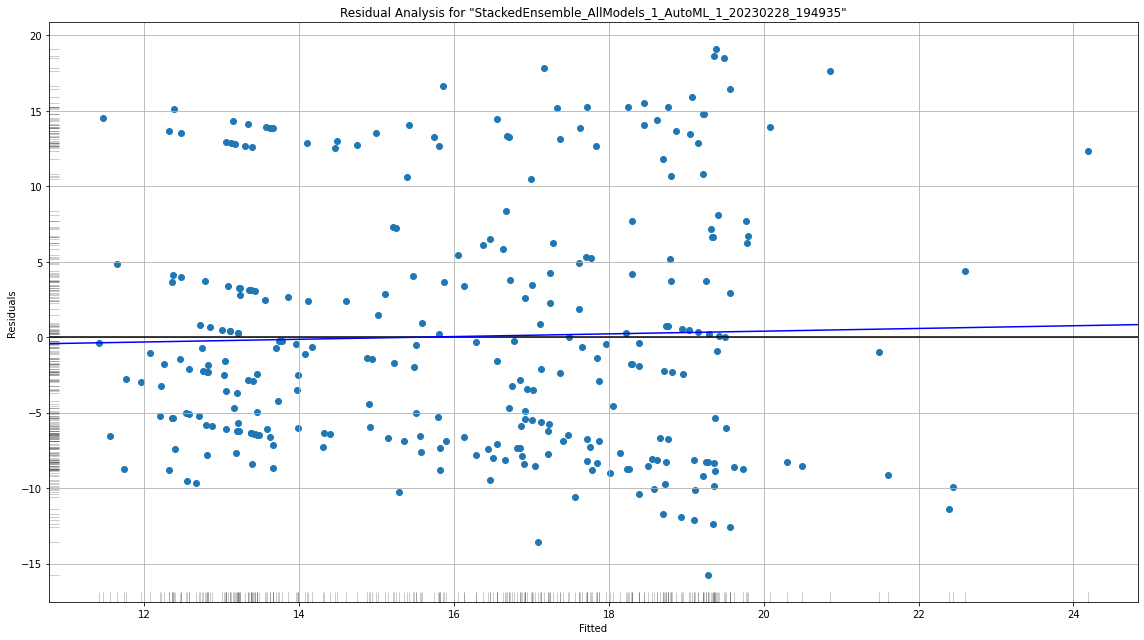

# Learning Curve Plot

> Learning curve plot shows the loss function/metric dependent on number of iterations or trees for tree-based algorithms. This plot can be useful for determining whether the model overfits.

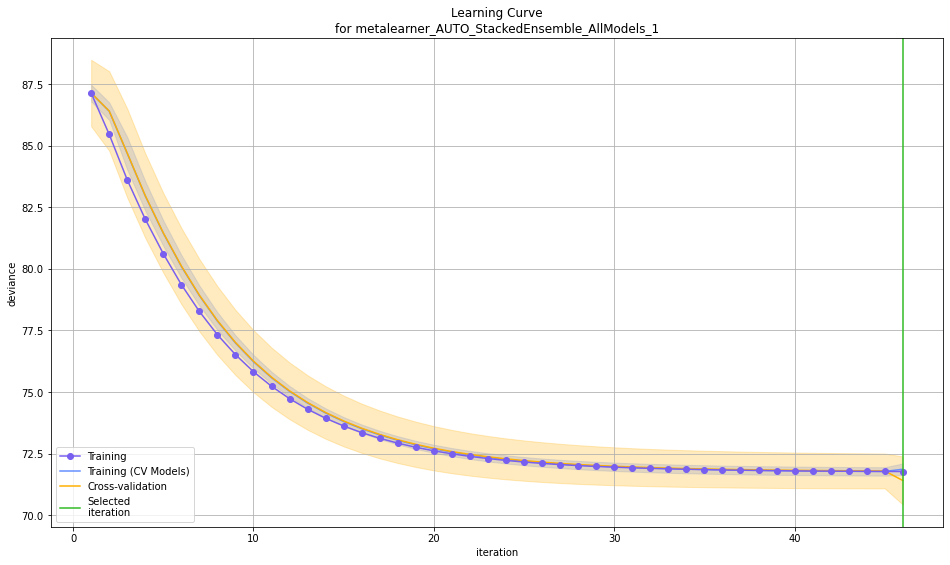

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

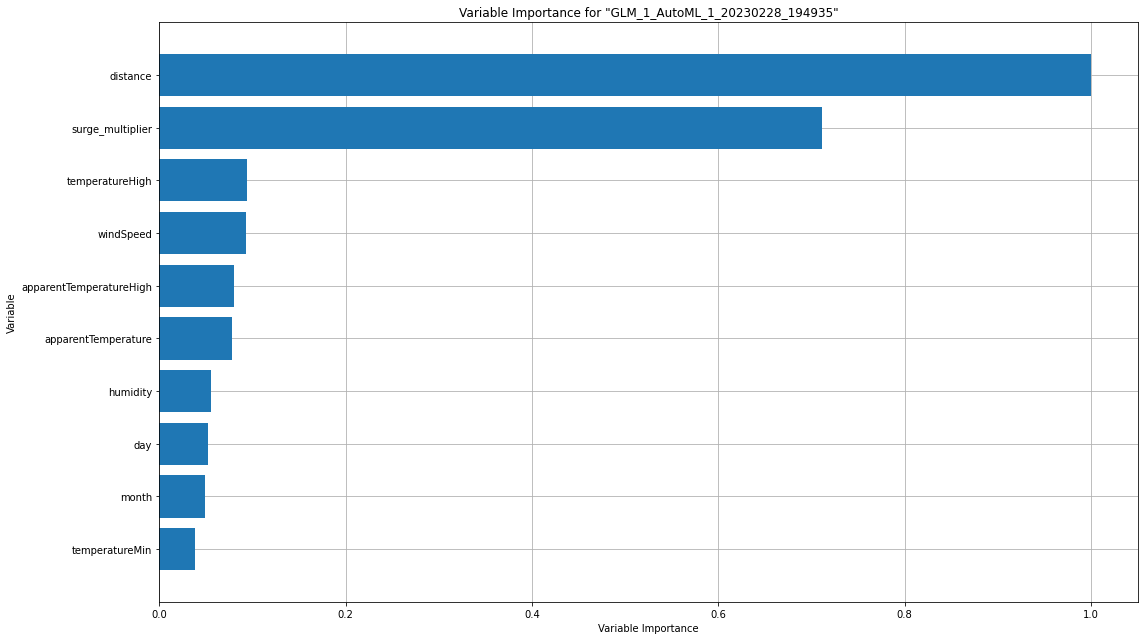

# Variable Importance Heatmap

> Variable importance heatmap shows variable importance across multiple models. Some models in H2O return variable importance for one-hot (binary indicator) encoded versions of categorical columns (e.g. Deep Learning, XGBoost). In order for the variable importance of categorical columns to be compared across all model types we compute a summarization of the the variable importance across all one-hot encoded features and return a single variable importance for the original categorical feature. By default, the models and variables are ordered by their similarity.

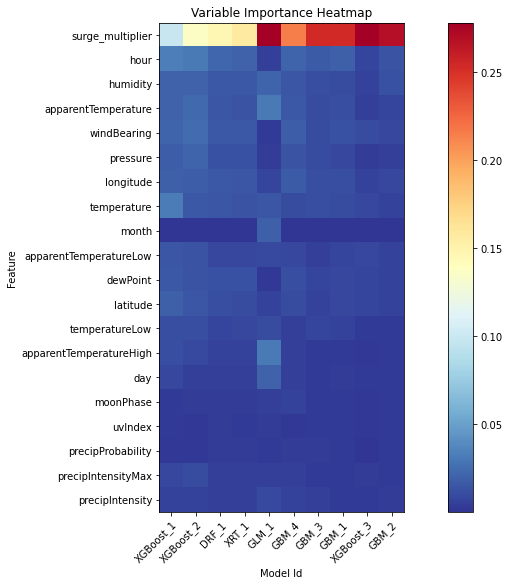

# Model Correlation

> This plot shows the correlation between the predictions of the models. For classification, frequency of identical predictions is used. By default, models are ordered by their similarity (as computed by hierarchical clustering). Interpretable models, such as GAM, GLM, and RuleFit are highlighted using red colored text.

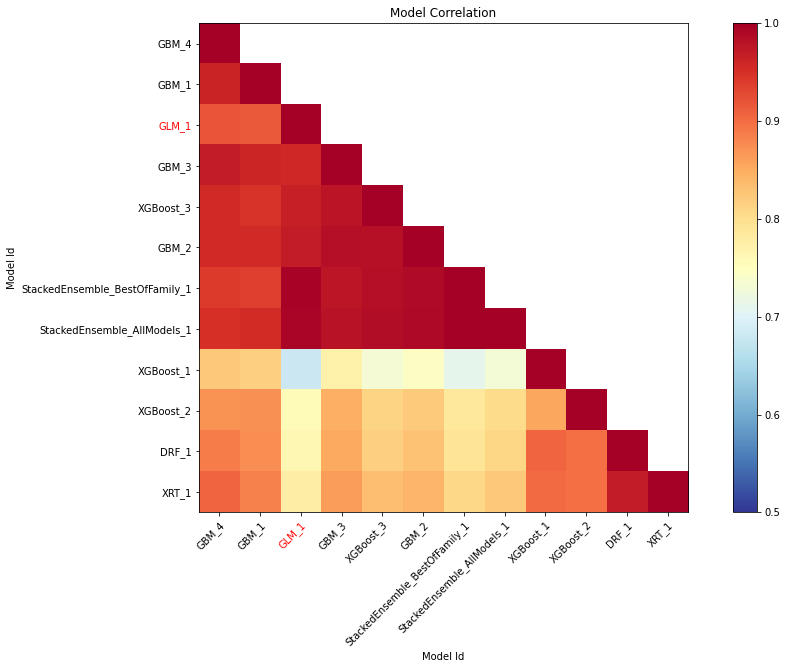

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

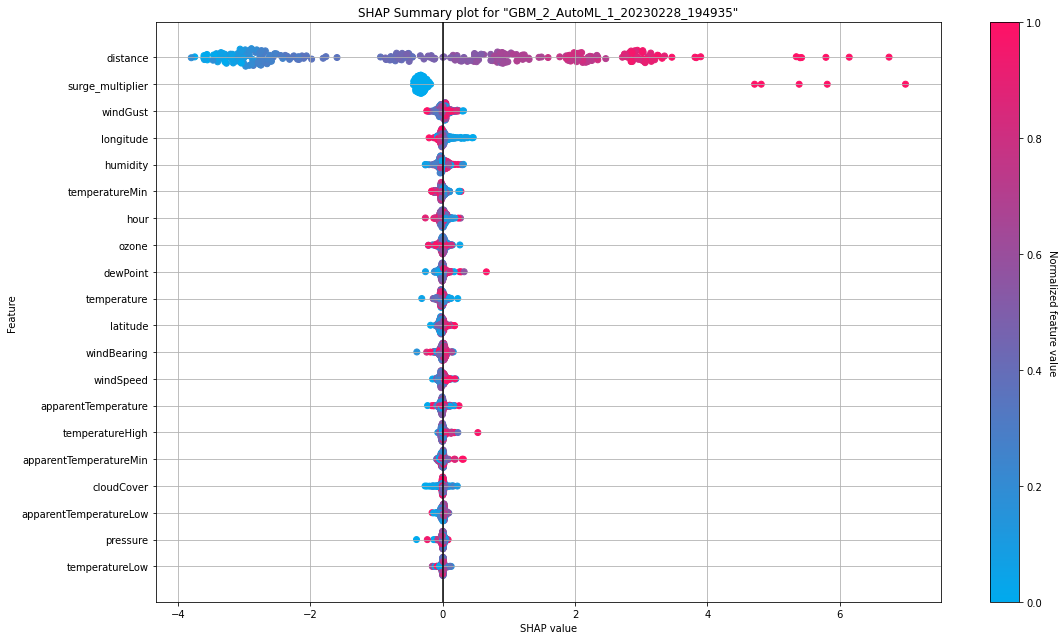

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

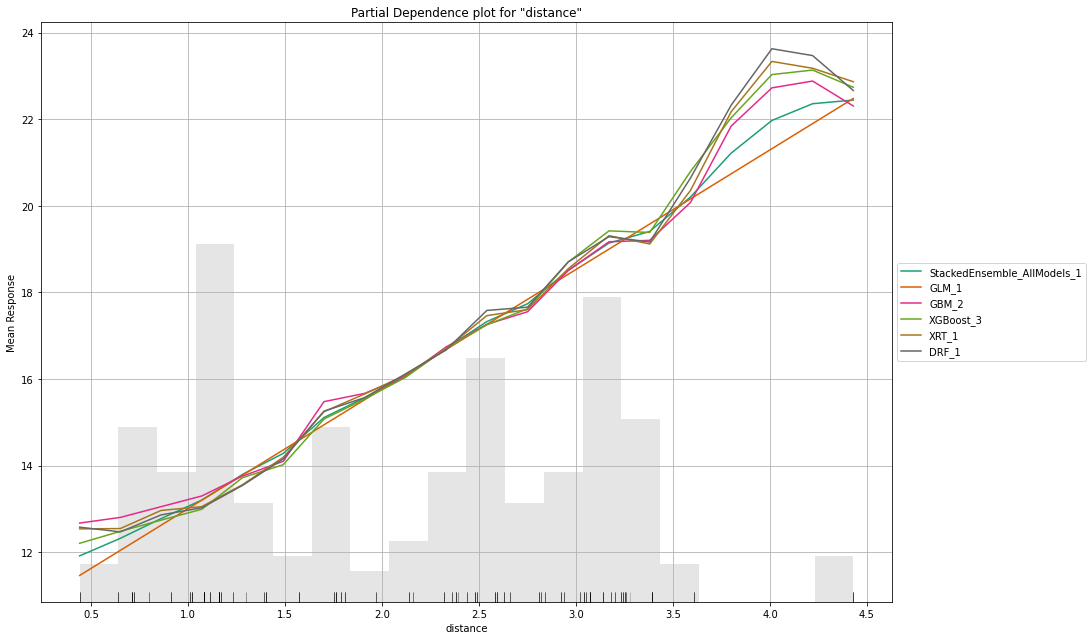

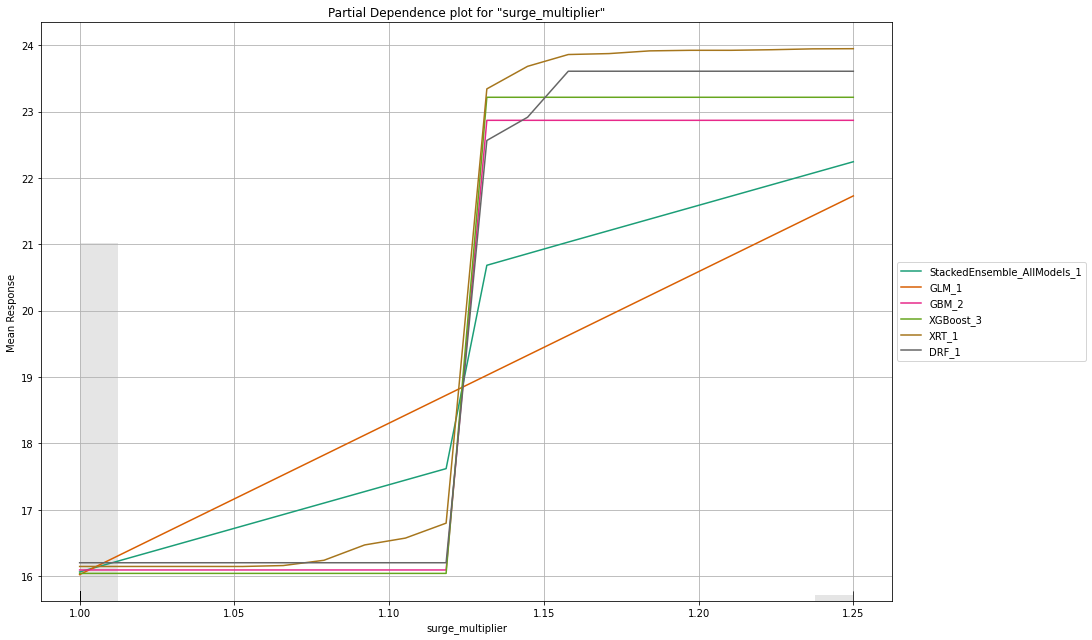

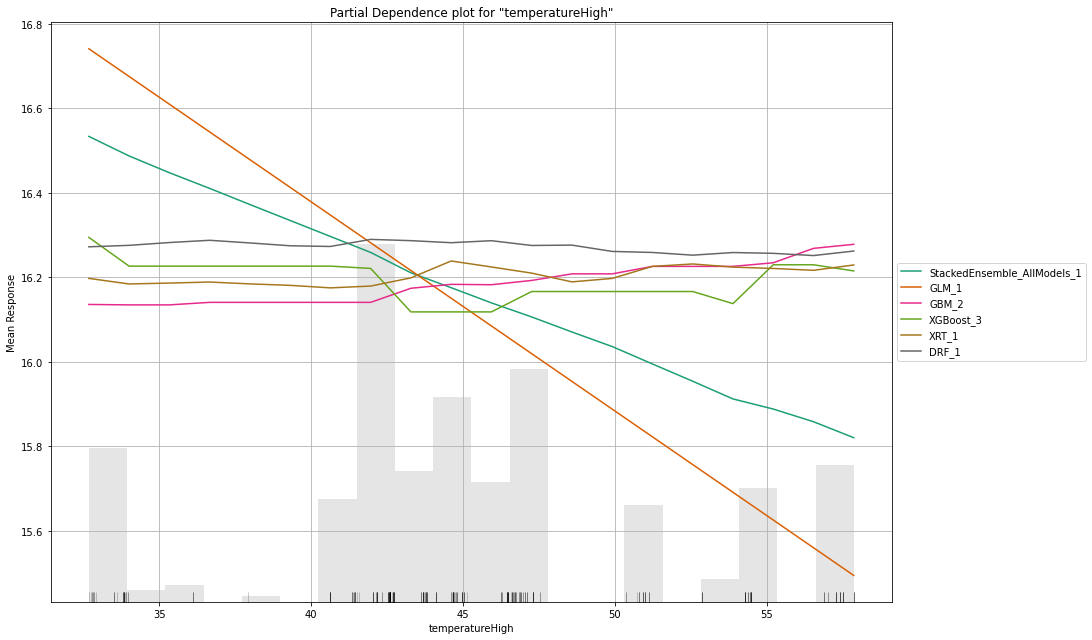

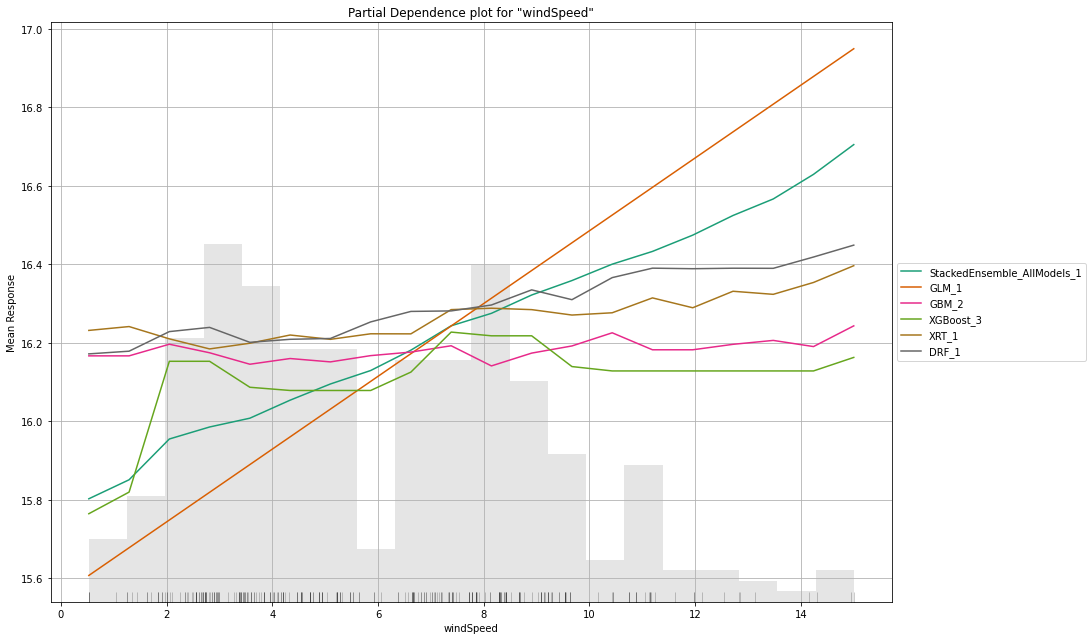

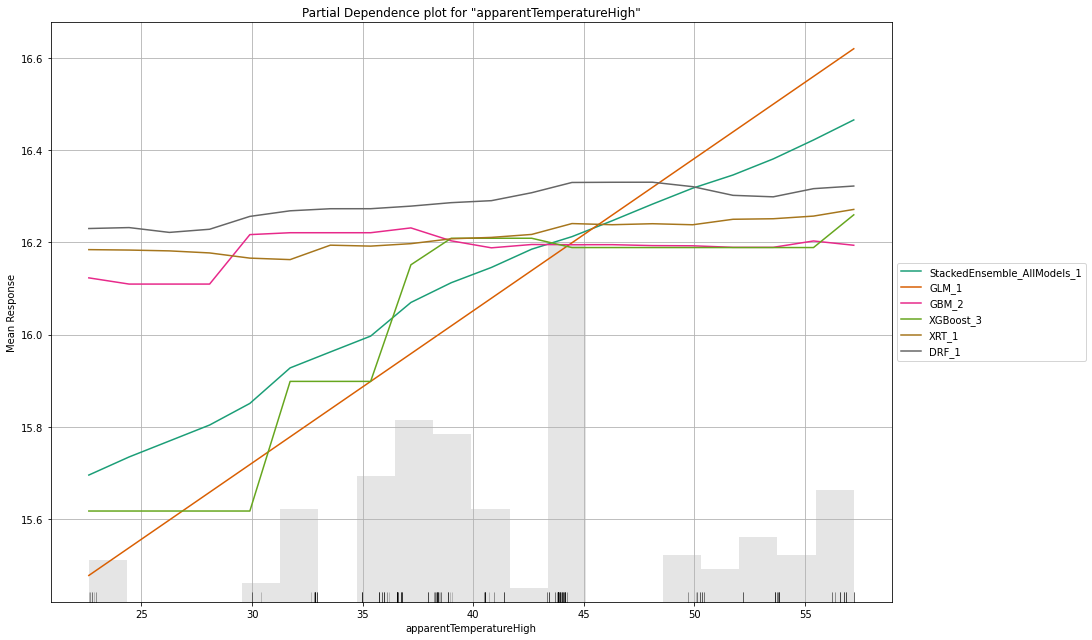

# Individual Conditional Expectation

> An Individual Conditional Expectation (ICE) plot gives a graphical depiction of the marginal effect of a variable on the response. ICE plots are similar to partial dependence plots (PDP); PDP shows the average effect of a feature while ICE plot shows the effect for a single instance. This function will plot the effect for each decile. In contrast to the PDP, ICE plots can provide more insight, especially when there is stronger feature interaction.

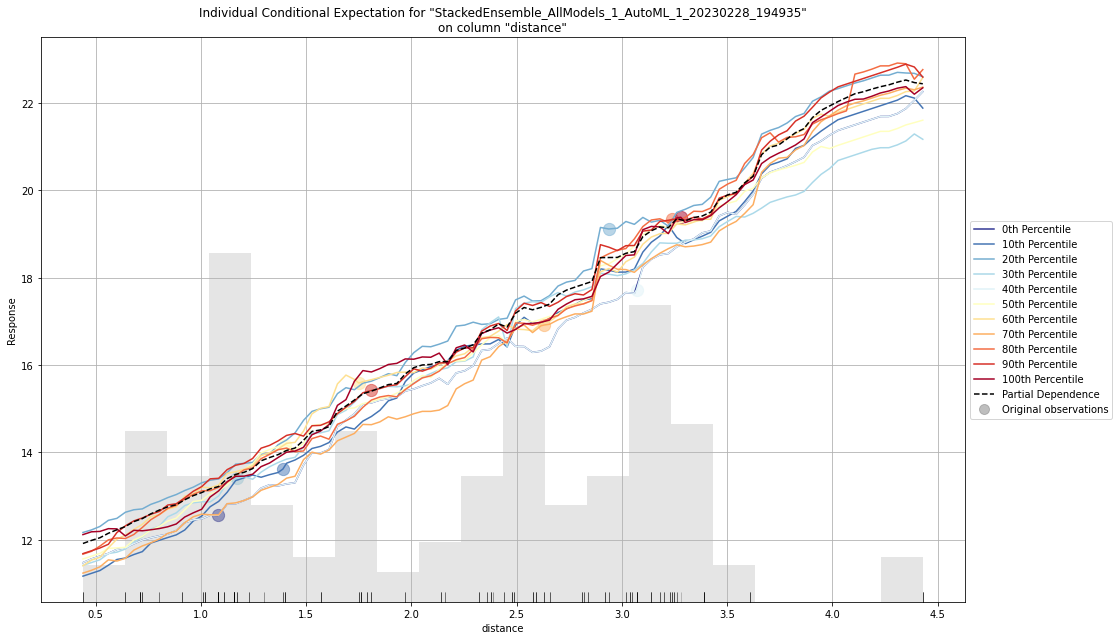

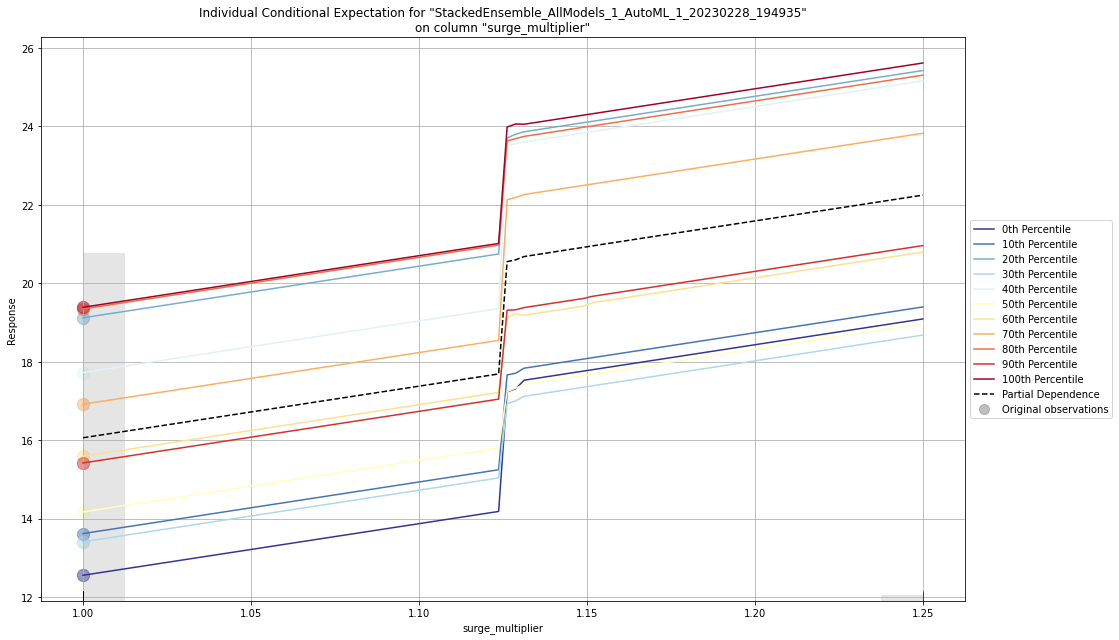

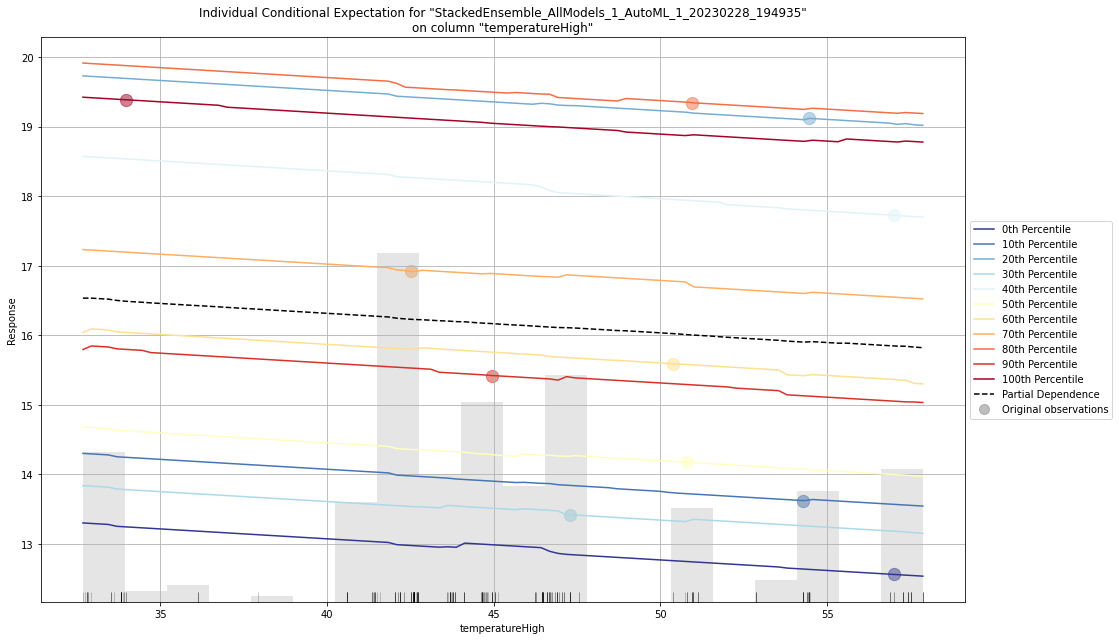

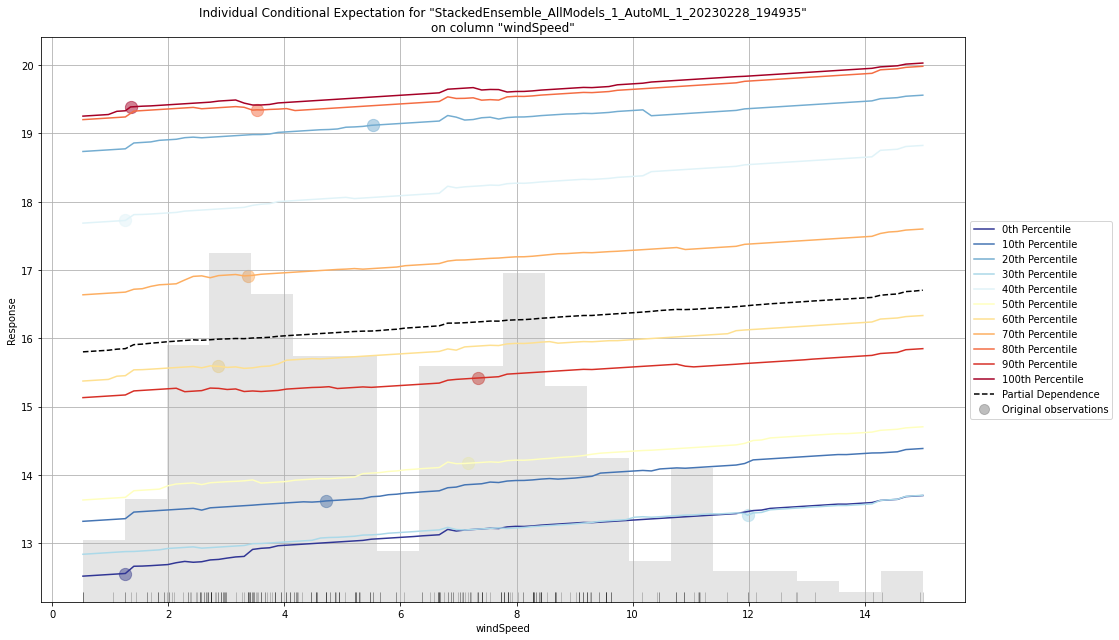

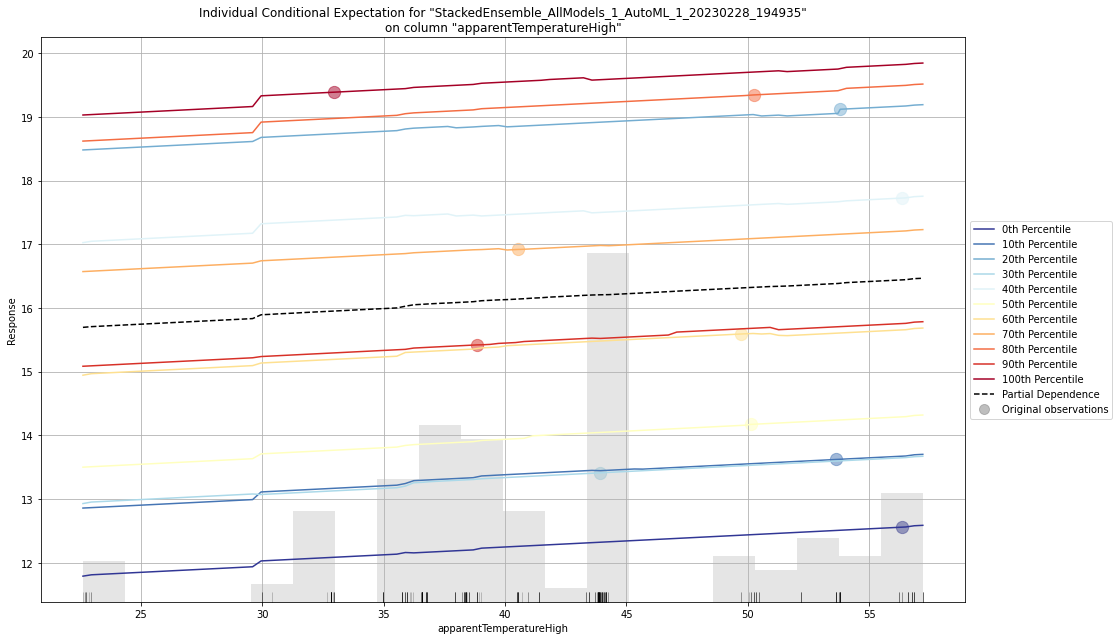

In [71]:
exa = aml.explain(train[0:300,:])

In [ ]:
pip install statsmodels

* In the multivariate models are predictor variables independent of all the other predictor variables?

In [72]:
import statsmodels.api as sm

In [73]:


model = sm.OLS(pandas_df['price'], pandas_df[['hour','day','month','distance','surge_multiplier','latitude','longitude','humidity','apparentTemperature','precipIntensity','precipProbability',
                        "temperature" ,'windSpeed','windGust','visibility','temperatureHigh','temperatureLow','apparentTemperatureHigh','apparentTemperatureLow','dewPoint','pressure','windBearing','cloudCover','uvIndex'
                         ,'visibility.1','ozone','moonPhase','precipIntensityMax','temperatureMin','apparentTemperatureMin']]).fit()




In [74]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.801
Model:                            OLS   Adj. R-squared (uncentered):              0.801
Method:                 Least Squares   F-statistic:                              8390.
Date:                Tue, 28 Feb 2023   Prob (F-statistic):                        0.00
Time:                        20:07:15   Log-Likelihood:                     -2.1476e+05
No. Observations:               60392   AIC:                                  4.296e+05
Df Residuals:                   60363   BIC:                                  4.298e+05
Df Model:                          29                                                  
Covariance Type:            nonrobust                                                  
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
hour                       -0.0072      0.006     -1.139      0.255      -0.019       0.005
day                        -0.0189      0.022     -0.880      0.379      -0.061       0.023
month                      -0.3028      0.484     -0.625      0.532      -1.252       0.646
distance                    2.7769      0.030     91.176      0.000       2.717       2.837
surge_multiplier           22.9622      0.354     64.874      0.000      22.268      23.656
latitude                    1.2332      0.905      1.362      0.173      -0.541       3.008
longitude                   0.8470      0.570      1.486      0.137      -0.270       1.964
humidity                    2.4939      4.030      0.619      0.536      -5.404      10.392
apparentTemperature         0.0528      0.045      1.179      0.239      -0.035       0.141
precipIntensity            -3.5597      2.766     -1.287      0.198      -8.981       1.862
precipProbability           0.0335      0.267      0.125      0.900      -0.490       0.557
temperature                -0.0092      0.128     -0.071      0.943      -0.261       0.243
windSpeed                   0.1052      0.054      1.962      0.050       0.000       0.210
windGust                   -0.0039      0.025     -0.159      0.874      -0.052       0.045
visibility                  0.0030      0.015      0.201      0.840      -0.026       0.032
temperatureHigh            -0.0876      0.048     -1.821      0.069      -0.182       0.007
temperatureLow             -0.0349      0.029     -1.203      0.229      -0.092       0.022
apparentTemperatureHigh     0.0495      0.032      1.524      0.128      -0.014       0.113
apparentTemperatureLow      0.0264      0.025      1.062      0.288      -0.022       0.075
dewPoint                   -0.0366      0.113     -0.325      0.746      -0.258       0.185
pressure                   -0.0022      0.010     -0.227      0.820      -0.021       0.017
windBearing                 0.0003      0.001      0.513      0.608      -0.001       0.002
cloudCover                 -0.0983      0.153     -0.642      0.521      -0.399       0.202
uvIndex                    -0.0683      0.084     -0.809      0.418      -0.234       0.097
visibility.1                0.0030      0.015      0.201      0.840      -0.026       0.032
ozone                       0.0020      0.004      0.562      0.574      -0.005       0.009
moonPhase                  -0.4491      0.515     -0.871      0.384      -1.459       0.561
precipIntensityMax         -1.0526      1.280     -0.822      0.411      -3.561       1.456
temperatureMin             -0.0357      0.034     -1.041      0.298      -0.103       0.032
apparentTemperatureMin      0.0540      

4) Is the relationship significant?

After conducting a statistical analysis to determine the significance of relationship to the target variable(price), only 2 predictor variables have a p-value below 0.05 (distance and surge_multiplier)

5) In in multivariate models rank the most significant predictor variables and exclude insignificant ones from the model.



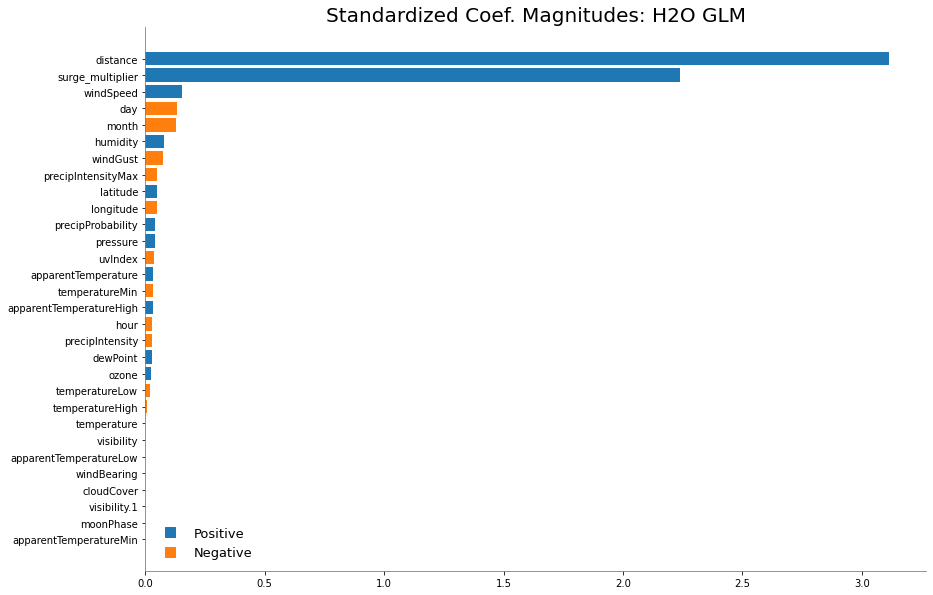

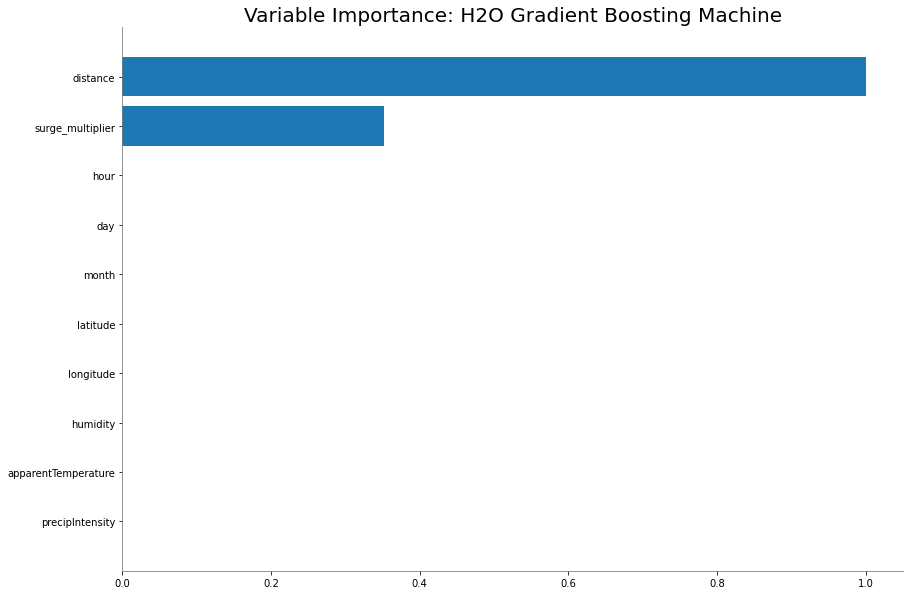

<Figure size 432x288 with 0 Axes>

In [75]:
data_glm.std_coef_plot()
data_gbm.varimp_plot()

# Residual Analysis

> Residual Analysis plots the fitted values vs residuals on a test dataset. Ideally, residuals should be randomly distributed. Patterns in this plot can indicate potential problems with the model selection, e.g., using simpler model than necessary, not accounting for heteroscedasticity, autocorrelation, etc. Note that if you see "striped" lines of residuals, that is an artifact of having an integer valued (vs a real valued) response variable.

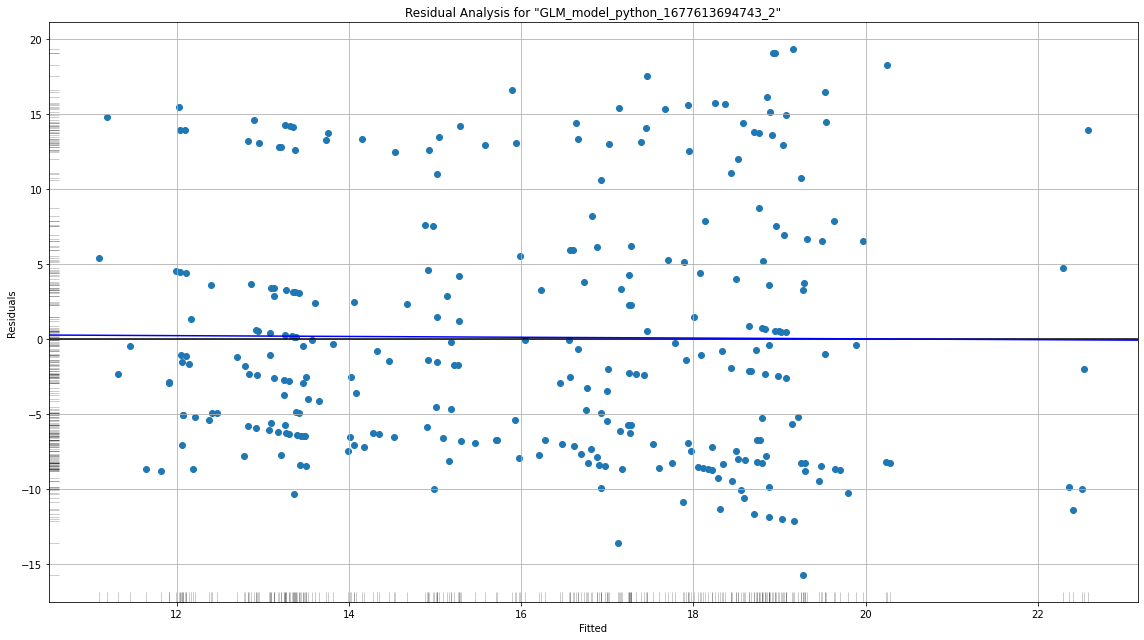

# Learning Curve Plot

> Learning curve plot shows the loss function/metric dependent on number of iterations or trees for tree-based algorithms. This plot can be useful for determining whether the model overfits.

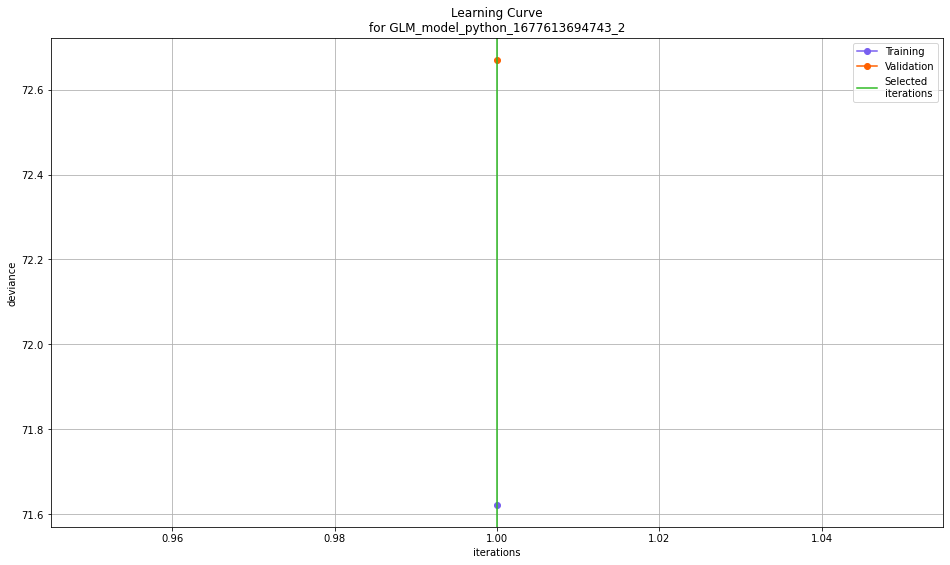

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

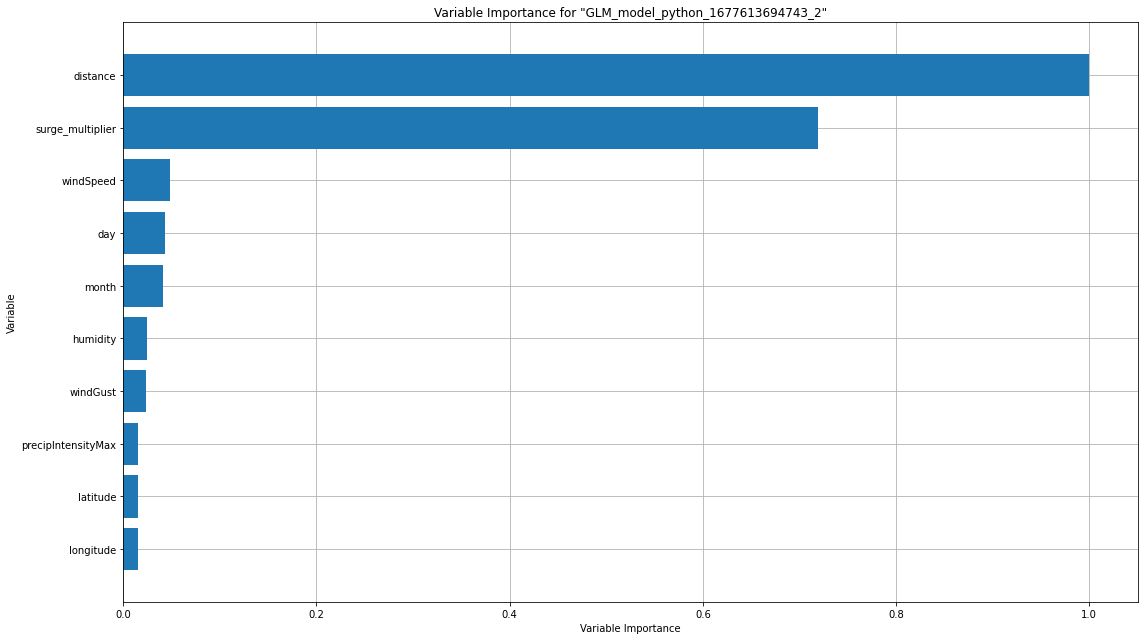

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

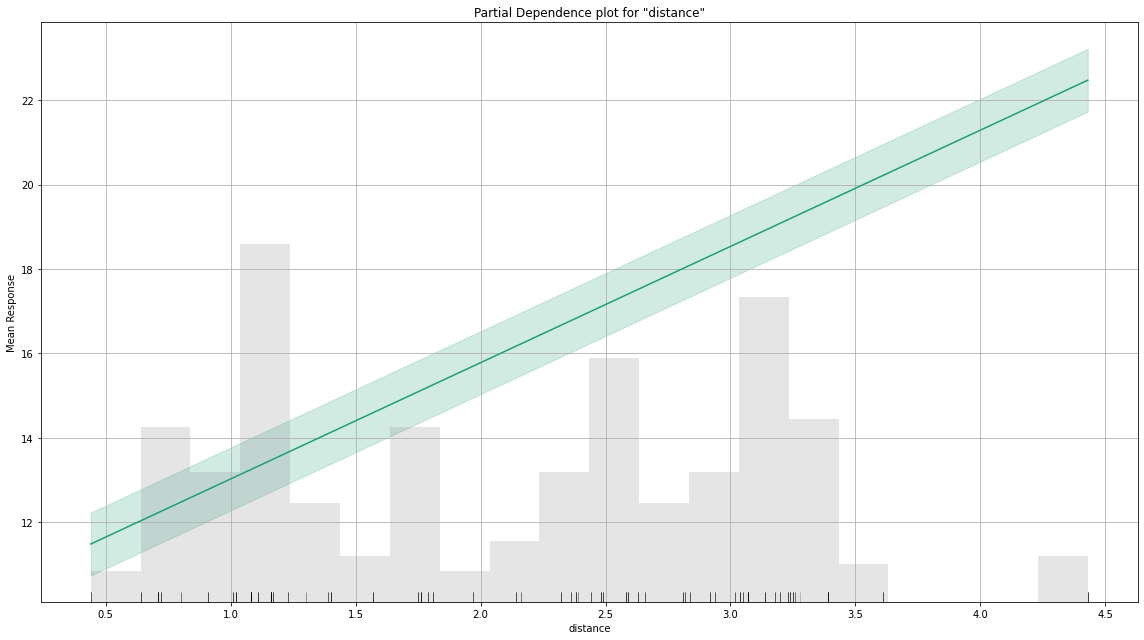

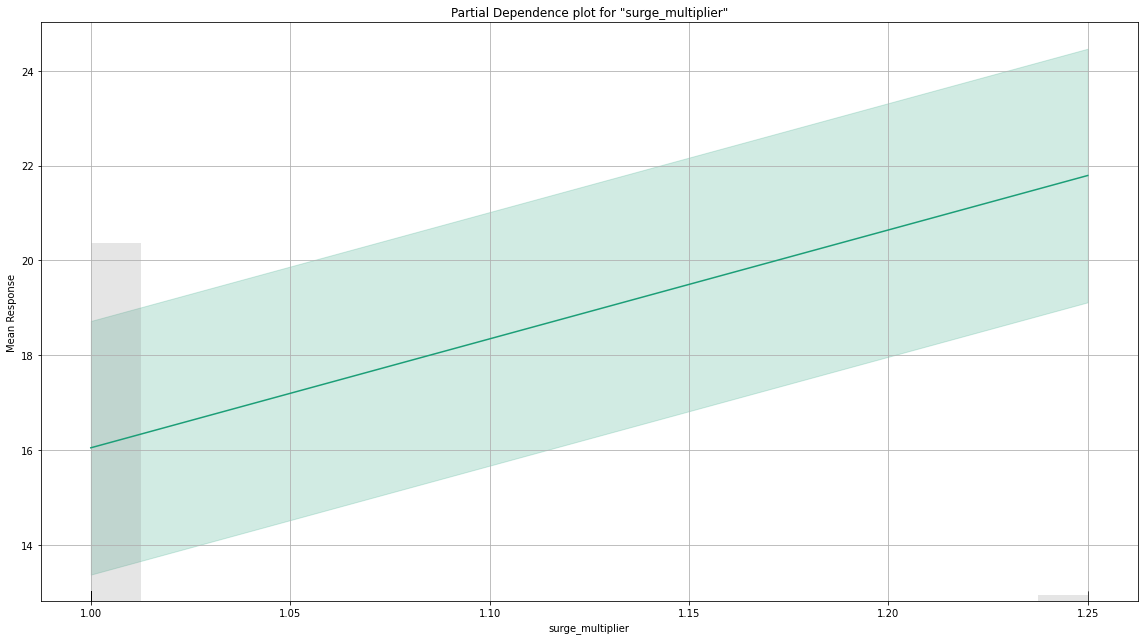

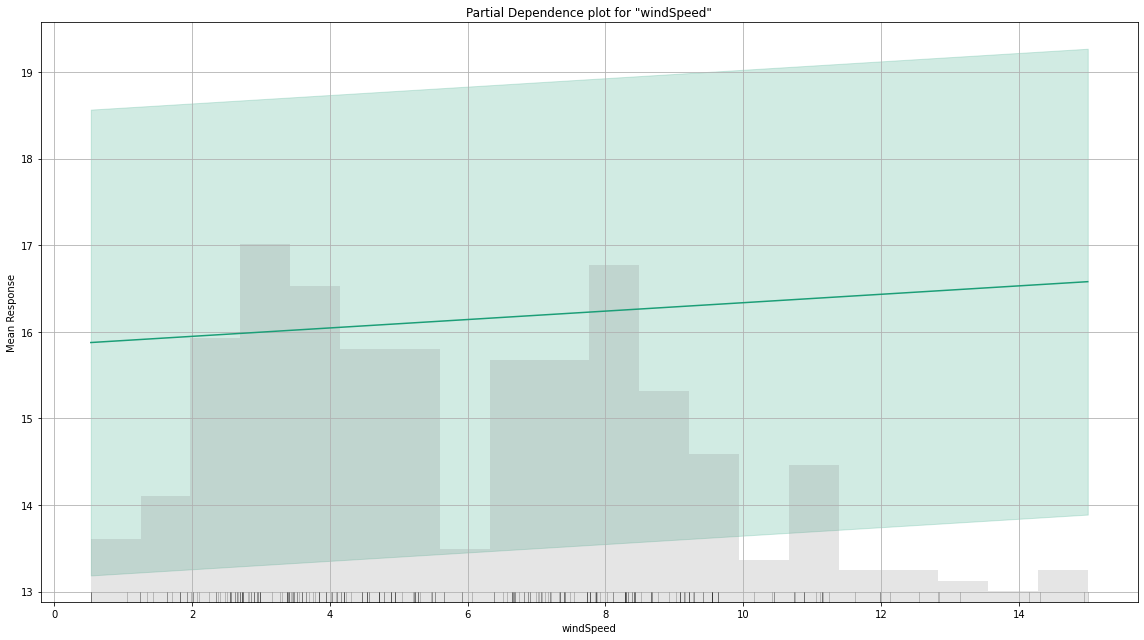

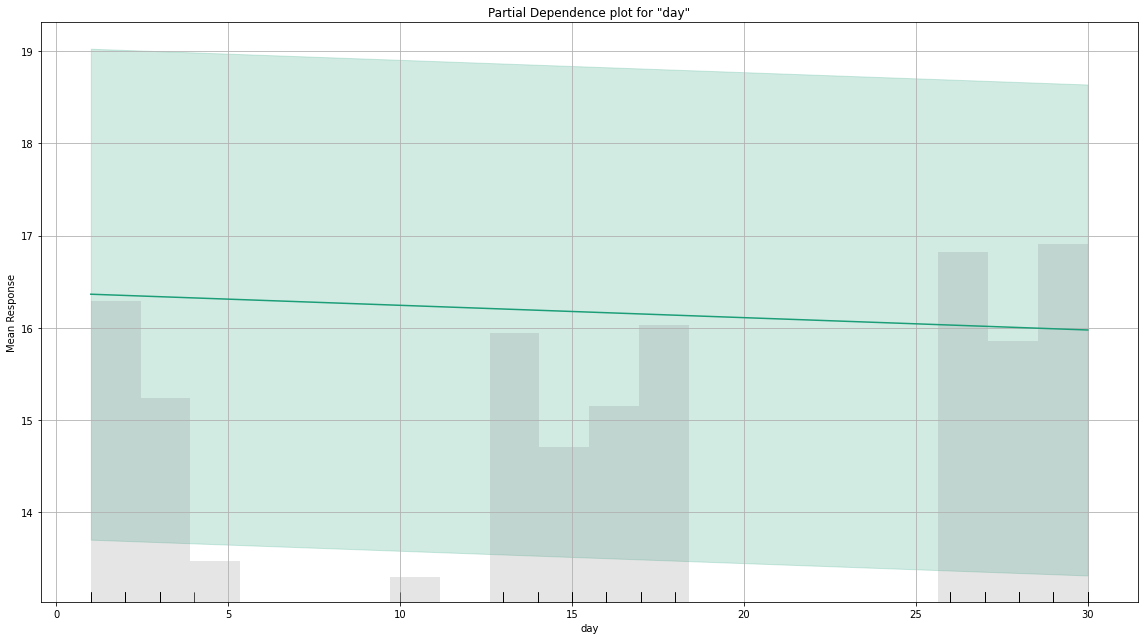

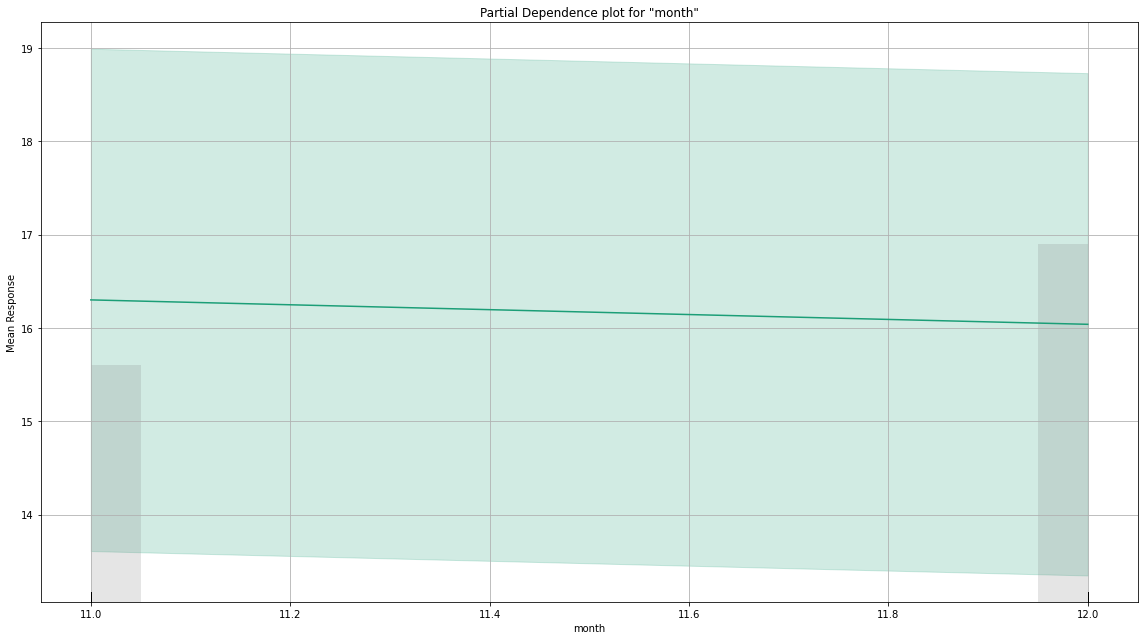

# Individual Conditional Expectation

> An Individual Conditional Expectation (ICE) plot gives a graphical depiction of the marginal effect of a variable on the response. ICE plots are similar to partial dependence plots (PDP); PDP shows the average effect of a feature while ICE plot shows the effect for a single instance. This function will plot the effect for each decile. In contrast to the PDP, ICE plots can provide more insight, especially when there is stronger feature interaction.

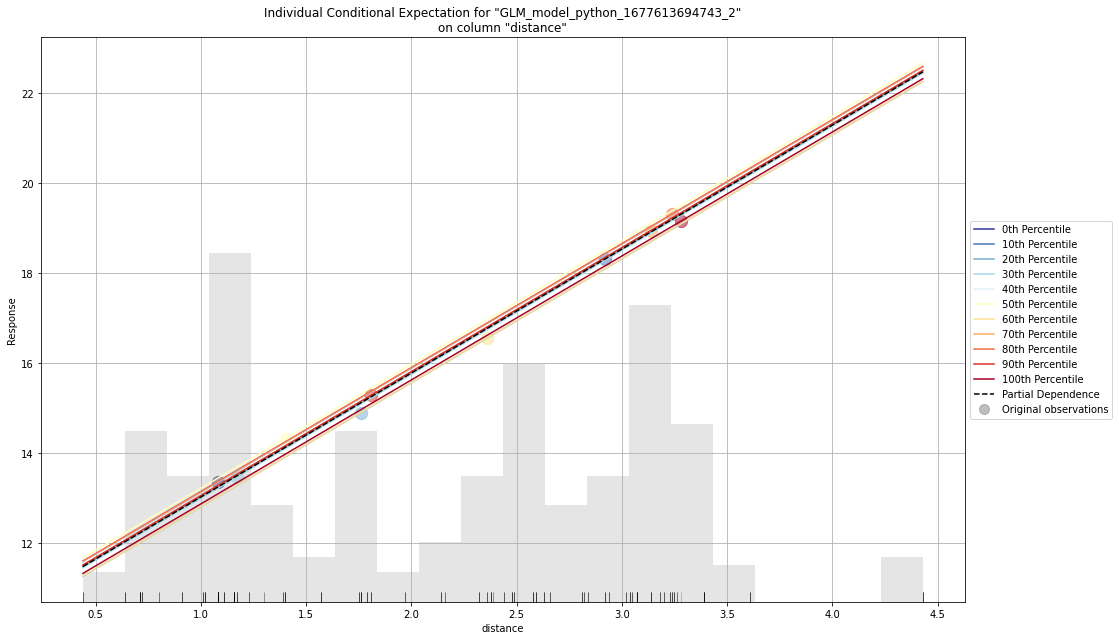

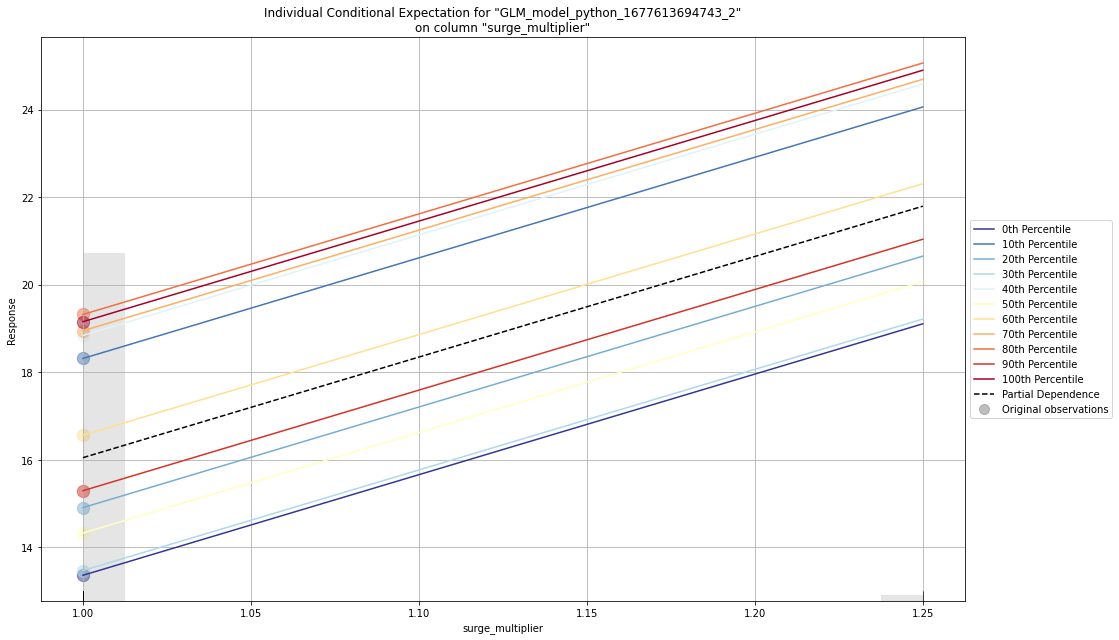

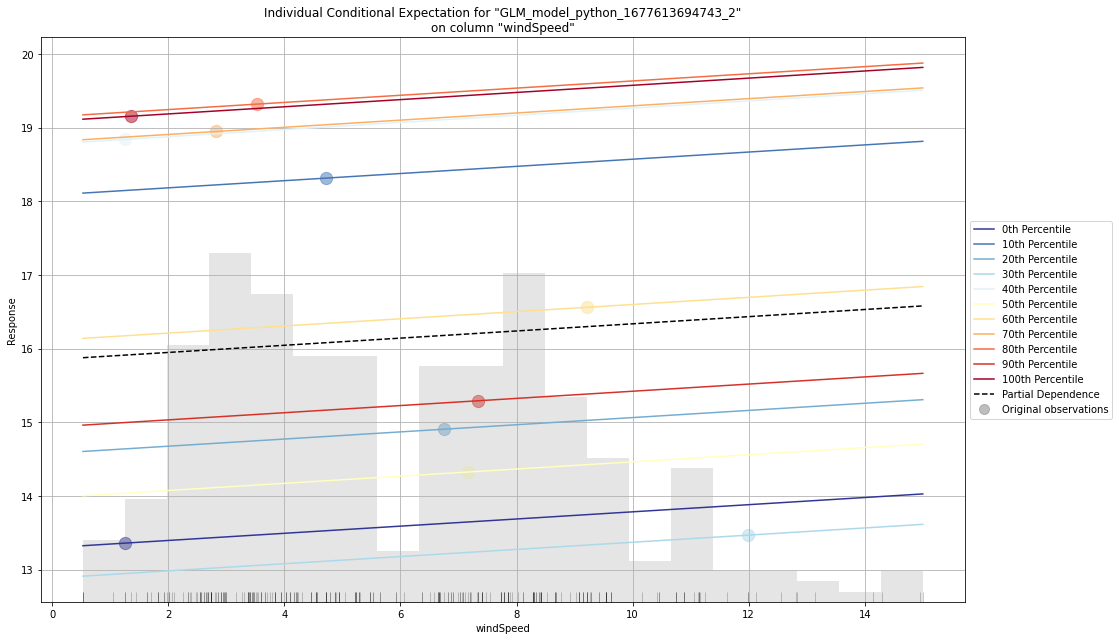

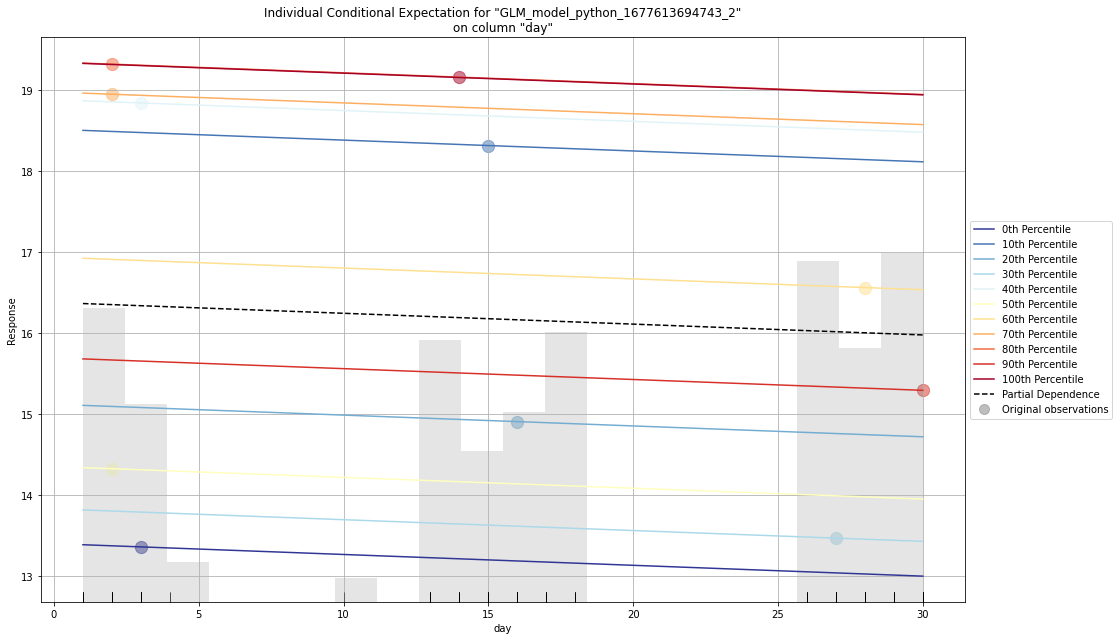

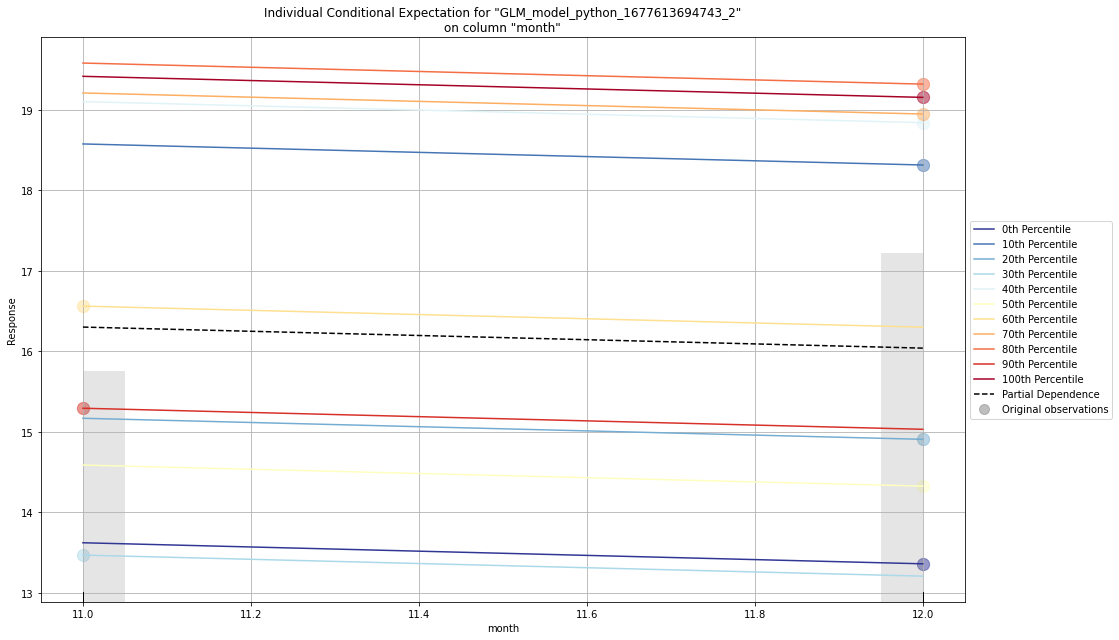

# Residual Analysis

> Residual Analysis plots the fitted values vs residuals on a test dataset. Ideally, residuals should be randomly distributed. Patterns in this plot can indicate potential problems with the model selection, e.g., using simpler model than necessary, not accounting for heteroscedasticity, autocorrelation, etc. Note that if you see "striped" lines of residuals, that is an artifact of having an integer valued (vs a real valued) response variable.

# Learning Curve Plot

> Learning curve plot shows the loss function/metric dependent on number of iterations or trees for tree-based algorithms. This plot can be useful for determining whether the model overfits.

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

# Individual Conditional Expectation

> An Individual Conditional Expectation (ICE) plot gives a graphical depiction of the marginal effect of a variable on the response. ICE plots are similar to partial dependence plots (PDP); PDP shows the average effect of a feature while ICE plot shows the effect for a single instance. This function will plot the effect for each decile. In contrast to the PDP, ICE plots can provide more insight, especially when there is stronger feature interaction.

In [76]:
data_glm.explain(train[1:300,:])

# Residual Analysis

> Residual Analysis plots the fitted values vs residuals on a test dataset. Ideally, residuals should be randomly distributed. Patterns in this plot can indicate potential problems with the model selection, e.g., using simpler model than necessary, not accounting for heteroscedasticity, autocorrelation, etc. Note that if you see "striped" lines of residuals, that is an artifact of having an integer valued (vs a real valued) response variable.

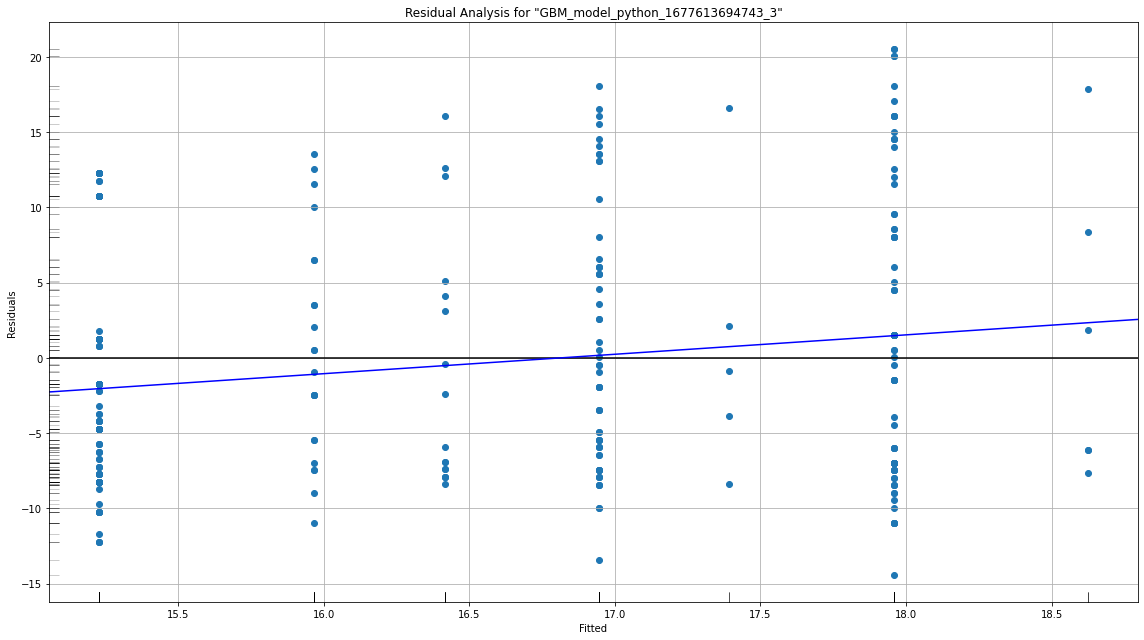

# Learning Curve Plot

> Learning curve plot shows the loss function/metric dependent on number of iterations or trees for tree-based algorithms. This plot can be useful for determining whether the model overfits.

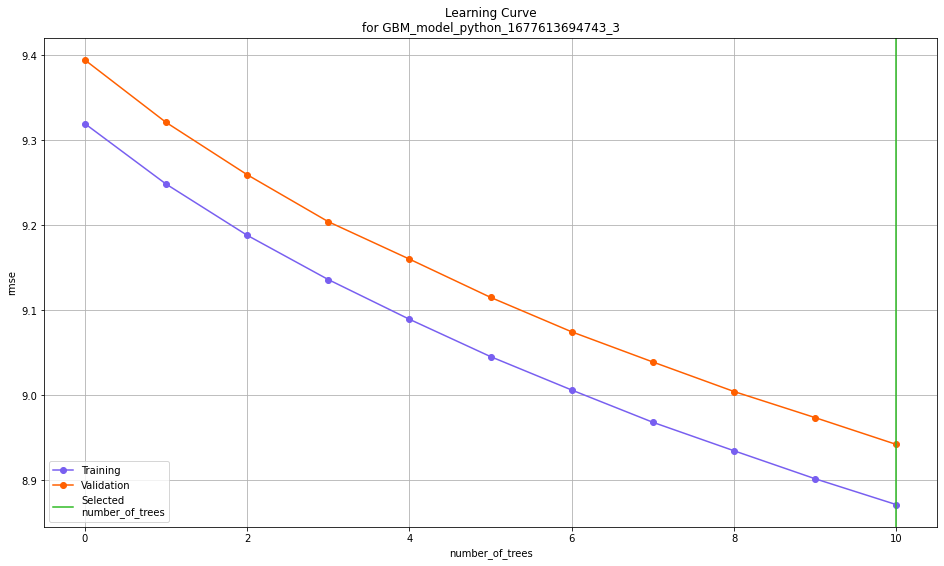

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

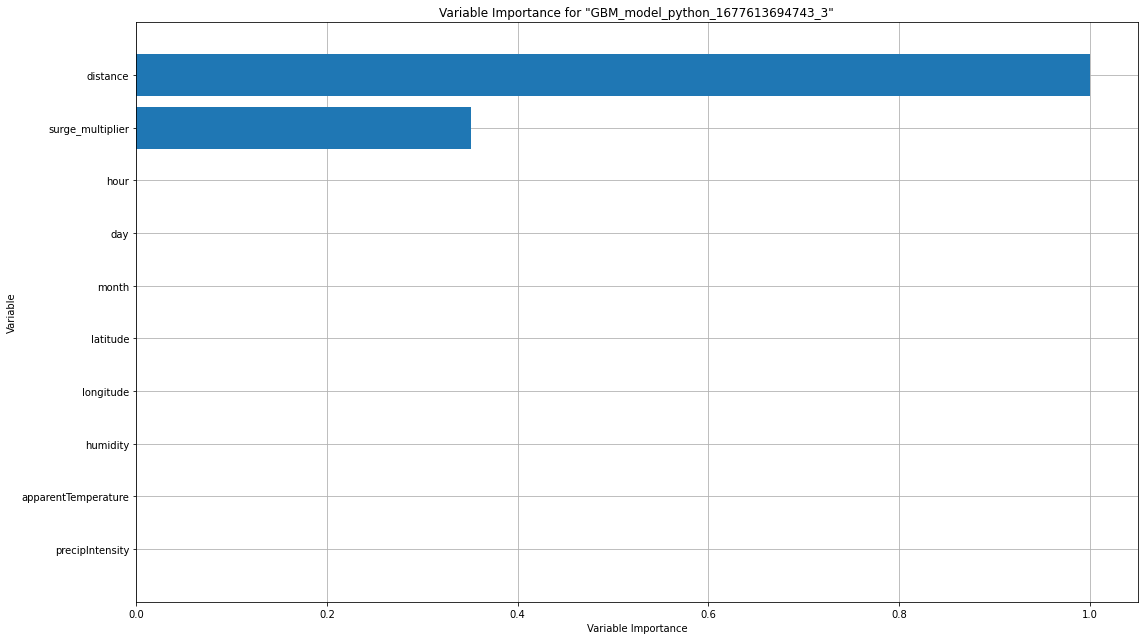

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

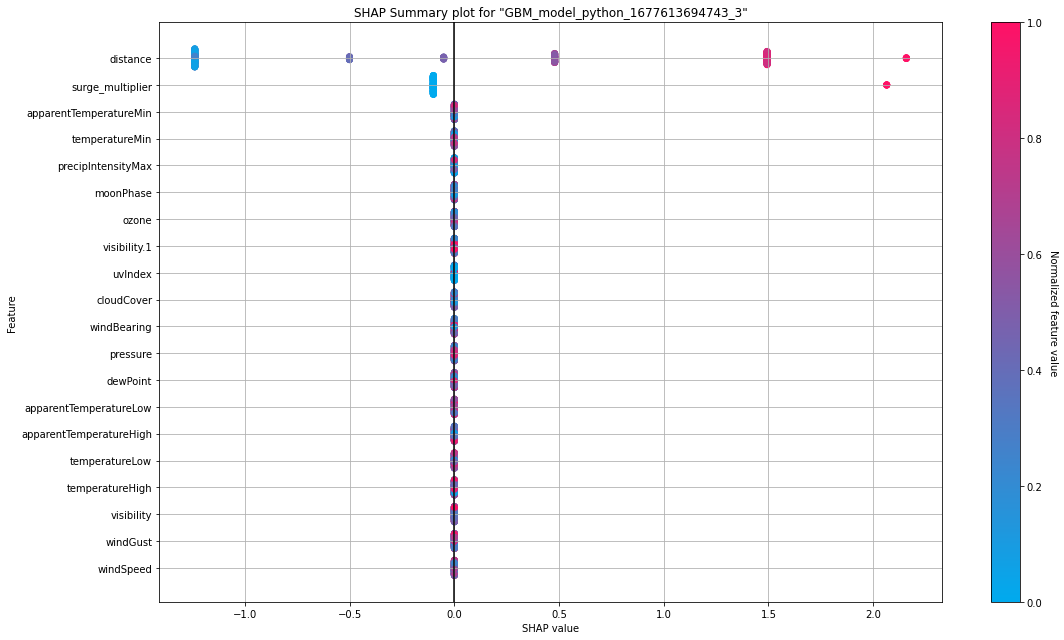

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

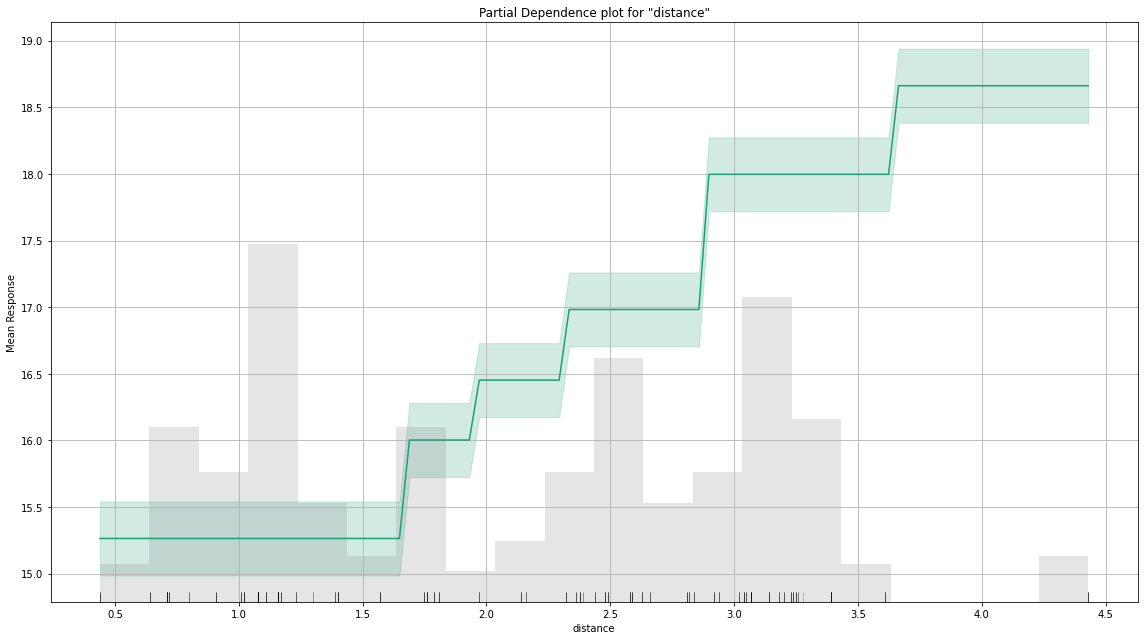

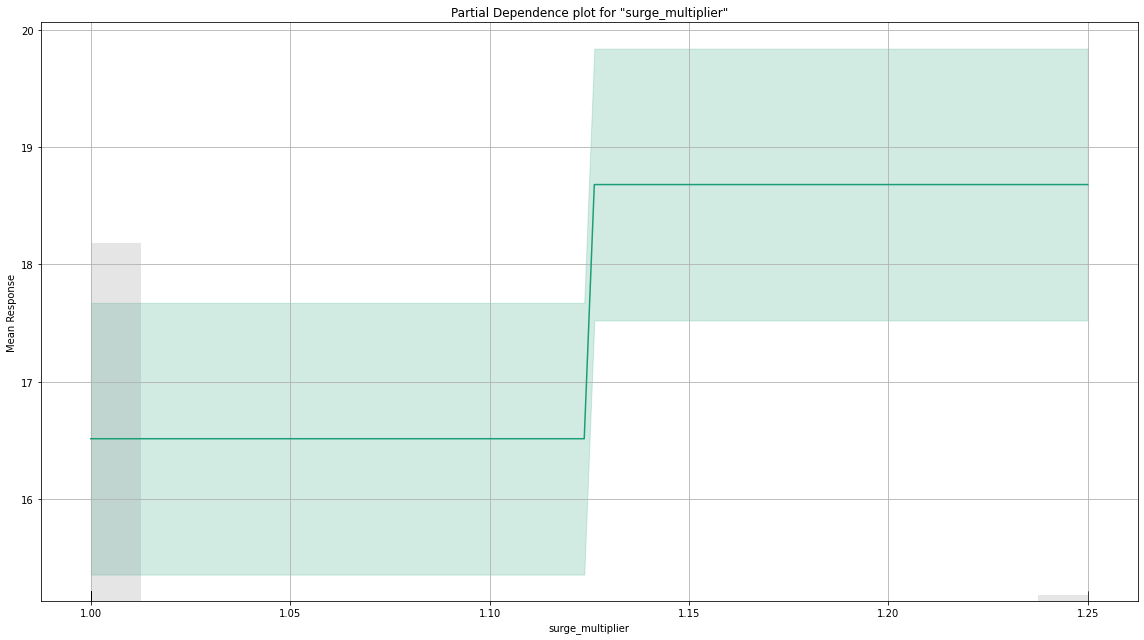

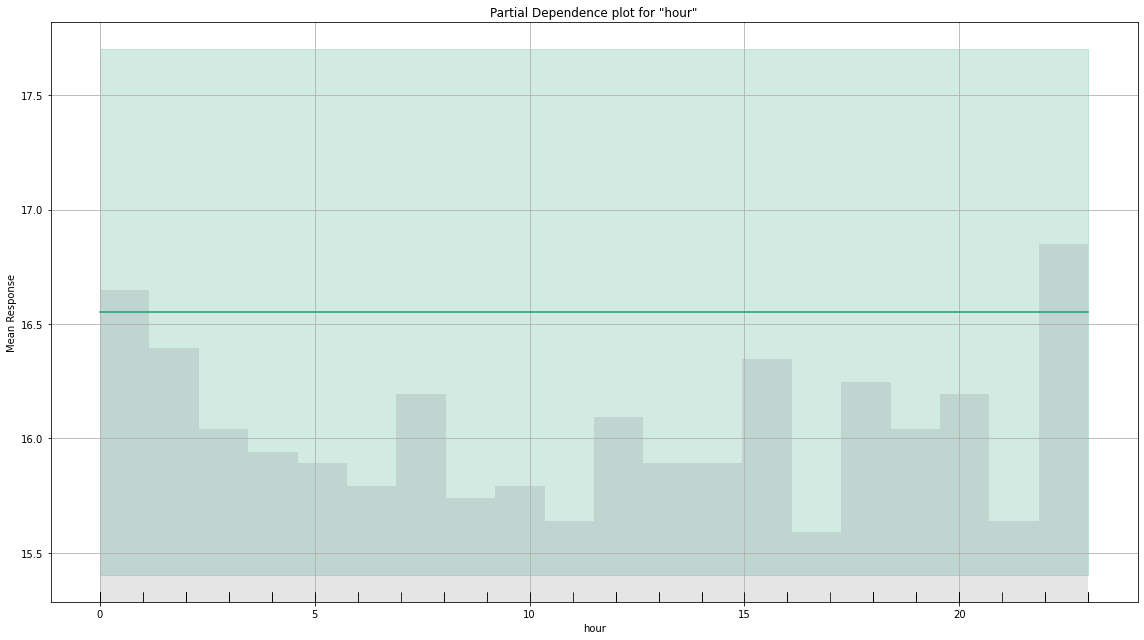

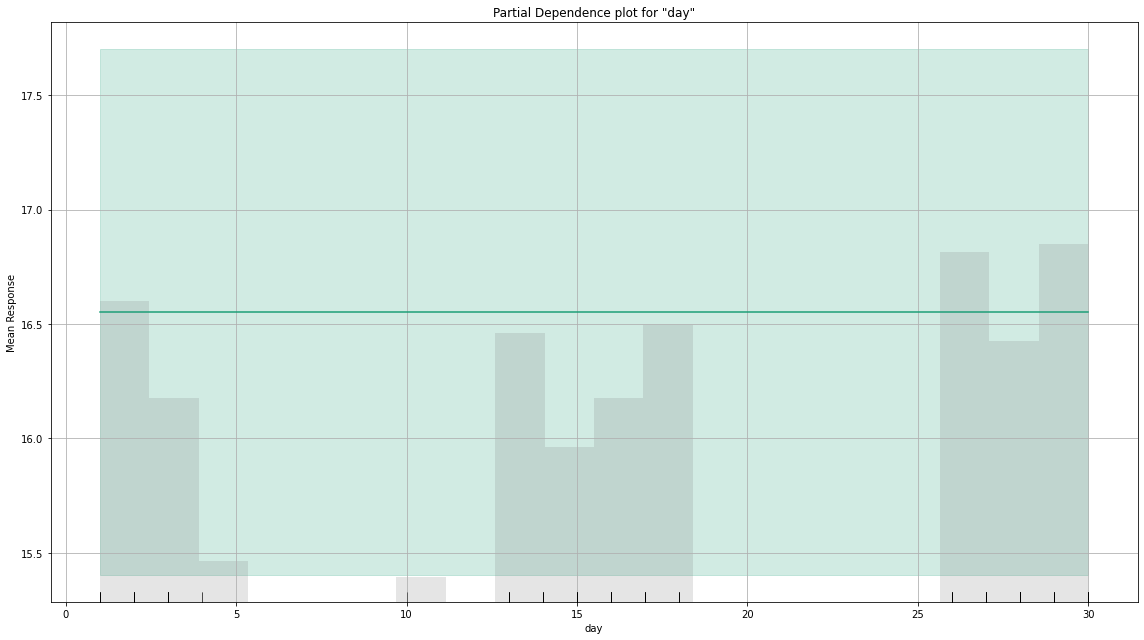

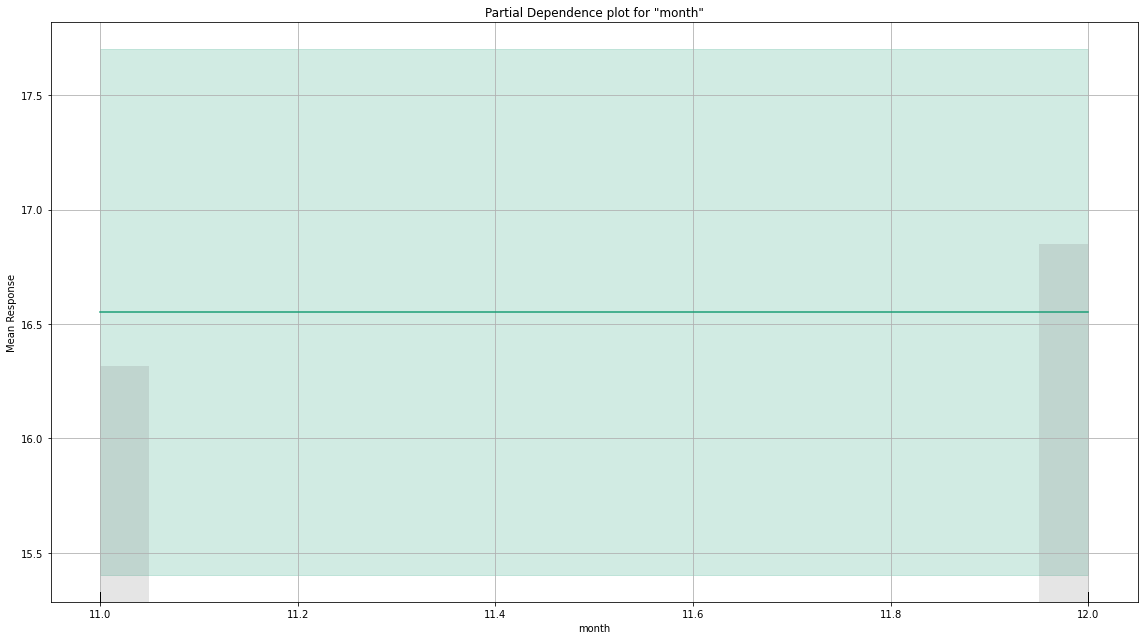

# Individual Conditional Expectation

> An Individual Conditional Expectation (ICE) plot gives a graphical depiction of the marginal effect of a variable on the response. ICE plots are similar to partial dependence plots (PDP); PDP shows the average effect of a feature while ICE plot shows the effect for a single instance. This function will plot the effect for each decile. In contrast to the PDP, ICE plots can provide more insight, especially when there is stronger feature interaction.

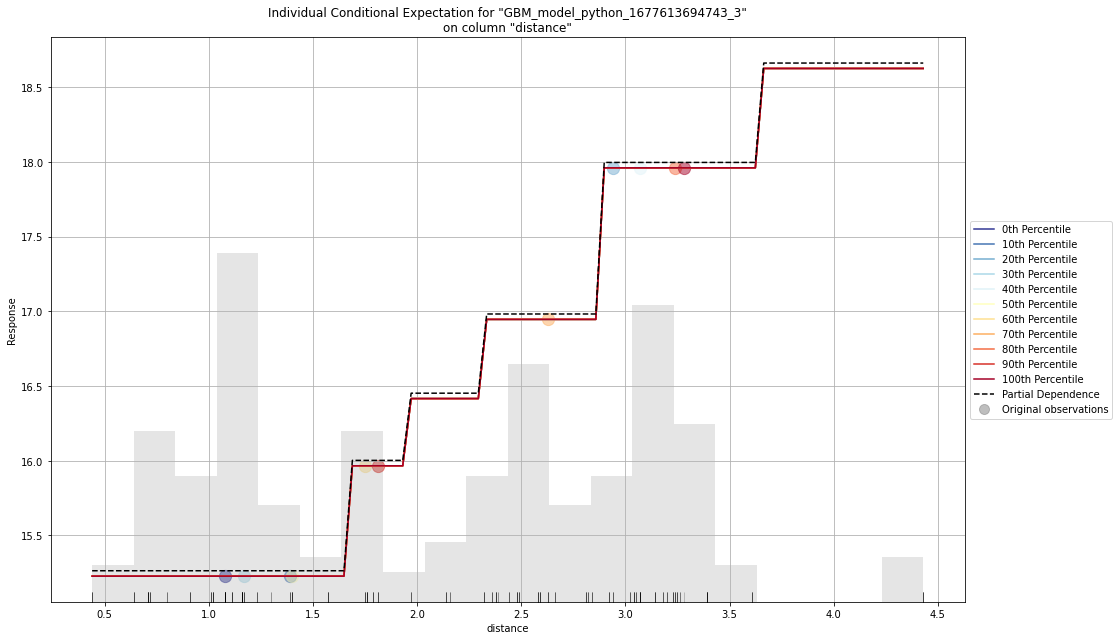

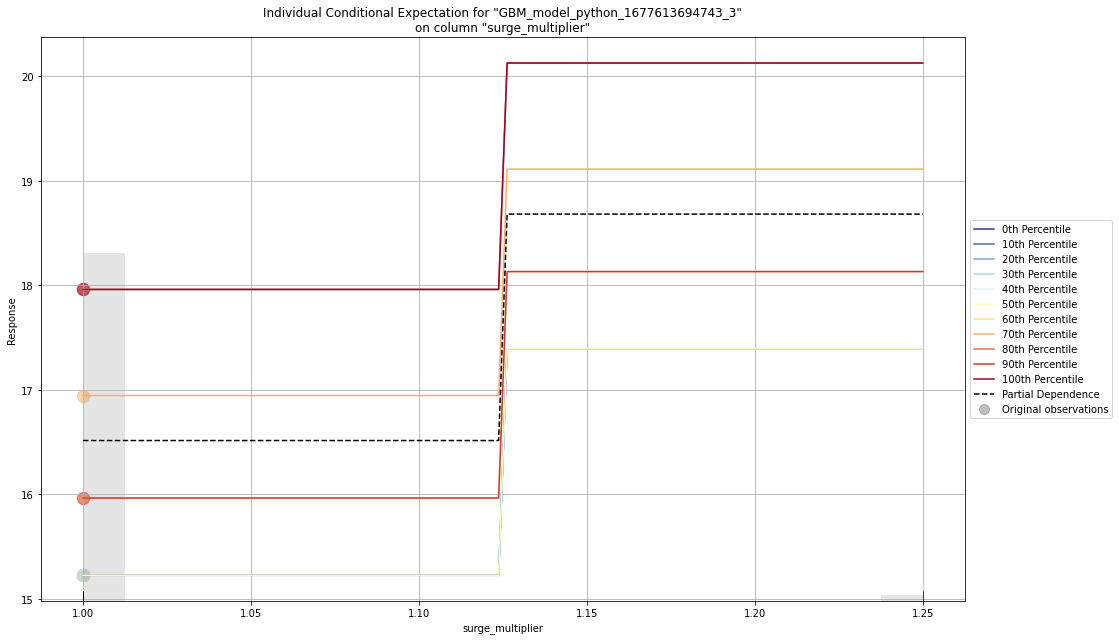

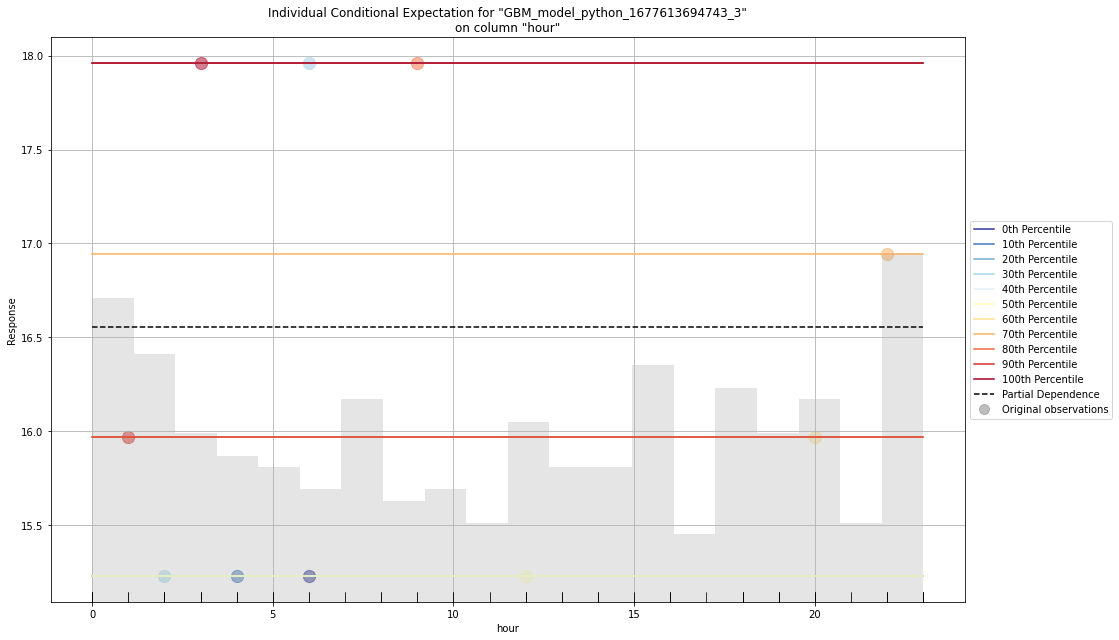

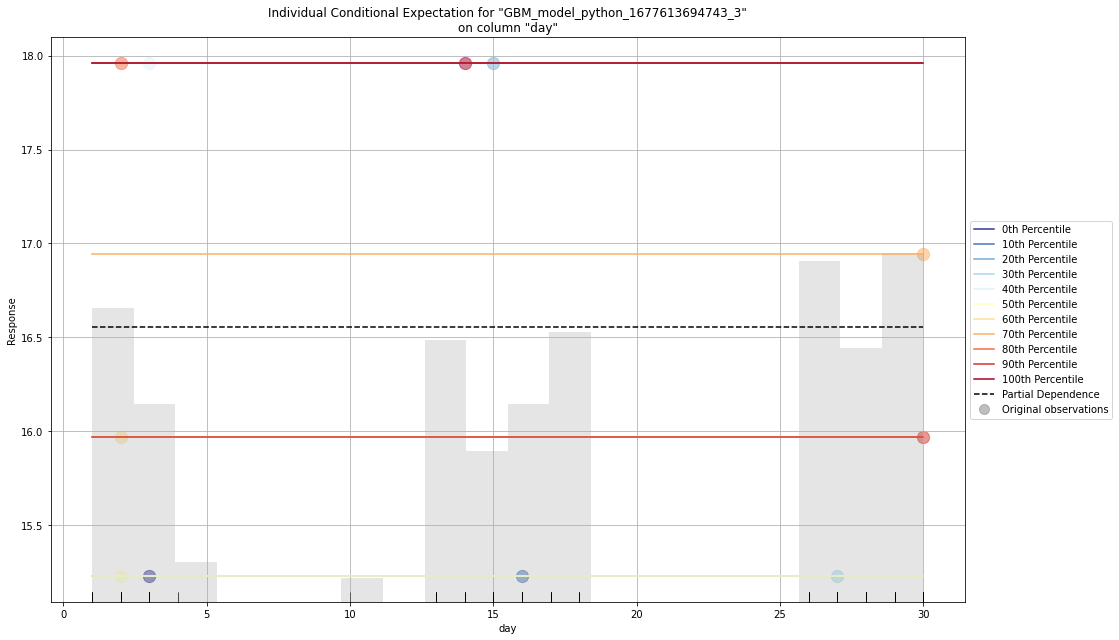

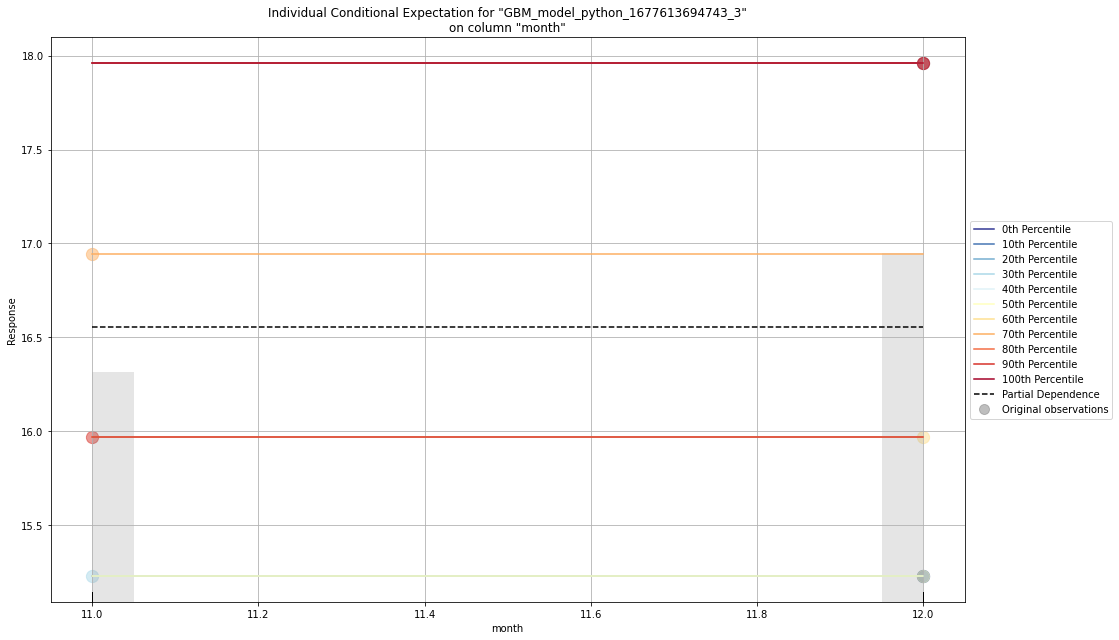

# Residual Analysis

> Residual Analysis plots the fitted values vs residuals on a test dataset. Ideally, residuals should be randomly distributed. Patterns in this plot can indicate potential problems with the model selection, e.g., using simpler model than necessary, not accounting for heteroscedasticity, autocorrelation, etc. Note that if you see "striped" lines of residuals, that is an artifact of having an integer valued (vs a real valued) response variable.

# Learning Curve Plot

> Learning curve plot shows the loss function/metric dependent on number of iterations or trees for tree-based algorithms. This plot can be useful for determining whether the model overfits.

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

# Individual Conditional Expectation

> An Individual Conditional Expectation (ICE) plot gives a graphical depiction of the marginal effect of a variable on the response. ICE plots are similar to partial dependence plots (PDP); PDP shows the average effect of a feature while ICE plot shows the effect for a single instance. This function will plot the effect for each decile. In contrast to the PDP, ICE plots can provide more insight, especially when there is stronger feature interaction.

In [77]:
data_gbm.explain(train[0:300,:])

This code calculates and displays the variable importances or feature importance scores for a trained Generalized Linear Model (GLM).

First, the magnitude of the normalized coefficients is calculated for each predictor variable in the GLM using the coef_norm() method of the GLM object data_glm. The absolute value of the coefficients is taken using abs() to ensure that both positive and negative coefficients are considered important.

The resulting variable importances are then sorted in descending order of magnitude using the sorted() function with the reverse=True argument. The items() method is used to obtain a list of key-value pairs for the dictionary of variable importances.

Finally, the sorted variable importances are printed as a table using the tabulate() function from the tabulate library. The table has two columns: "Predictor" and "Normalized Coefficient", and the format of the table is specified as "orgtbl".

In [78]:
data_glm.varimp()

[('distance', 3.114530086517334, 1.0, 0.48462418101048405),
 ('surge_multiplier',
  2.2383482456207275,
  0.7186792817672368,
  0.34828935833565006),
 ('windSpeed', 0.15233731269836426, 0.04891181284708916, 0.023703847242758657),
 ('day', 0.13359086215496063, 0.042892782681172255, 0.020786879678123777),
 ('month', 0.12928402423858643, 0.04150996158240736, 0.020116731135650826),
 ('humidity', 0.07665490359067917, 0.024612028608269006, 0.01192758420728897),
 ('windGust', 0.07491712272167206, 0.02405406935896527, 0.011657183663057923),
 ('precipIntensityMax',
  0.04874837398529053,
  0.01565191943282877,
  0.007585298636376722),
 ('latitude', 0.0480777733027935, 0.015436605833708303, 0.007480952459742546),
 ('longitude',
  0.04771389067173004,
  0.015319771954774625,
  0.007424331936850035),
 ('precipProbability',
  0.04307163134217262,
  0.013829255183190508,
  0.0067019914671386915),
 ('pressure', 0.03949841111898422, 0.012681980915827763, 0.006145994614923618),
 ('uvIndex', 0.036948595

In [79]:
data_gbm.varimp()

[('distance', 1533949.625, 1.0, 0.739850884885472),
 ('surge_multiplier', 539373.0625, 0.35162371287127503, 0.260149115114528),
 ('hour', 0.0, 0.0, 0.0),
 ('day', 0.0, 0.0, 0.0),
 ('month', 0.0, 0.0, 0.0),
 ('latitude', 0.0, 0.0, 0.0),
 ('longitude', 0.0, 0.0, 0.0),
 ('humidity', 0.0, 0.0, 0.0),
 ('apparentTemperature', 0.0, 0.0, 0.0),
 ('precipIntensity', 0.0, 0.0, 0.0),
 ('precipProbability', 0.0, 0.0, 0.0),
 ('temperature', 0.0, 0.0, 0.0),
 ('windSpeed', 0.0, 0.0, 0.0),
 ('windGust', 0.0, 0.0, 0.0),
 ('visibility', 0.0, 0.0, 0.0),
 ('temperatureHigh', 0.0, 0.0, 0.0),
 ('temperatureLow', 0.0, 0.0, 0.0),
 ('apparentTemperatureHigh', 0.0, 0.0, 0.0),
 ('apparentTemperatureLow', 0.0, 0.0, 0.0),
 ('dewPoint', 0.0, 0.0, 0.0),
 ('pressure', 0.0, 0.0, 0.0),
 ('windBearing', 0.0, 0.0, 0.0),
 ('cloudCover', 0.0, 0.0, 0.0),
 ('uvIndex', 0.0, 0.0, 0.0),
 ('visibility.1', 0.0, 0.0, 0.0),
 ('ozone', 0.0, 0.0, 0.0),
 ('moonPhase', 0.0, 0.0, 0.0),
 ('precipIntensityMax', 0.0, 0.0, 0.0),
 ('temperatu

In [80]:
def get_independent_variables(df, targ):
    C = [name for name in df.columns if name != targ]
    # determine column types
    ints, reals, enums = [], [], []
    for key, val in df.types.items():
        if key in C:

            if val == 'enum':
                enums.append(key)
            elif val == 'int':
                ints.append(key)            
            else: 
                reals.append(key)    
    x=ints+enums+reals
    return x

In [81]:
X=get_independent_variables(train, myY) 
print(X)
print(myY)

['hour', 'day', 'month', 'windBearing', 'uvIndex', 'distance', 'surge_multiplier', 'latitude', 'longitude', 'humidity', 'apparentTemperature', 'precipIntensity', 'precipProbability', 'temperature', 'windSpeed', 'windGust', 'visibility', 'temperatureHigh', 'temperatureLow', 'apparentTemperatureHigh', 'apparentTemperatureLow', 'dewPoint', 'pressure', 'cloudCover', 'visibility.1', 'ozone', 'moonPhase', 'precipIntensityMax', 'temperatureMin', 'apparentTemperatureMin']
price


In [82]:
# Set up AutoML
run_time=333
aml = H2OAutoML(max_runtime_secs=run_time)

In [83]:
model_start_time = time.time()
  
aml.train(x=X,y=myY,training_frame=train) 

AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OGeneralizedLinearEstimator : Generalized Linear Modeling
Model Key: GLM_1_AutoML_2_20230228_200852


GLM Model: summary
    family    link      regularization               lambda_search                                                                number_of_predictors_total    number_of_active_predictors    number_of_iterations    training_frame
--  --------  --------  ---------------------------  ---------------------------------------------------------------------------  ----------------------------  -----------------------------  ----------------------  ------------------------------------------------
    gaussian  identity  Ridge ( lambda = 0.003427 )  nlambda = 30, lambda.max = 316.56, lambda.min = 0.003427, lambda.1se = -1.0  30                            30                             25                      AutoML_2_20230228_200852_training_py_16_sid_a3b5

ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 71.47946939190413
RMSE: 8.45455317517751
MAE: 6.934218257460194
RMSLE: 0.4976205107281255
Mean Residual Deviance: 71.47946939190413
R^2: 0.1760519199253121
Null degrees of freedom: 33773
Residual degrees of freedom: 33743
Null deviance: 2929975.39240981
Residual deviance: 2414147.5992421703
AIC: 240105.52240177628

ModelMetricsRegressionGLM: glm
** Reported on validation data. **

MSE: 71.5083660452306
RMSE: 8.456261942798994
MAE: 6.915710519790992
RMSLE: 0.503305398149804
Mean Residual Deviance: 71.5083660452306
R^2: 0.1704615705978153
Null degrees of freedom: 4886
Residual degrees of freedom: 4856
Null deviance: 421448.6767644678
Residual deviance: 349461.3848630419
AIC: 34799.28844304168

Scoring History: 
     timestamp            duration    iteration    lambda    predictors    deviance_train     deviance_test      alpha    iterations    training_rmse     training_deviance    training_mae       training_r2         validation_rmse    validation_deviance    validation_mae     validation_r2
---  -------------------  ----------  -----------  --------  ------------  -----------------  -----------------  -------  ------------  ----------------  -------------------  -----------------  ------------------  -----------------  ---------------------  -----------------  ------------------
     2023-02-28 20:09:01  0.000 sec   1            .32E3     30            86.6531833611947   86.14493821539538  0.0
     2023-02-28 20:09:01  0.032 sec   2            .2E3      31            86.59312565774387  86.08816726796161  0.0
     2023-02-28 20:09:01  0.066 sec   3            .12E3     31            86.49716346725447  85.99745014539722  0.0
     2023-02-28 20:09:01  0.097 sec   4            .76E2     31            86.3445795437152   85.85322654929894  0.0
     2023-02-28 20:09:01  0.125 sec   5            .47E2     31            86.10383854309177  85.625683348102    0.0      5             8.45455317517751  71.47946939190413    6.934218257460194  0.1760519199253121  8.456261942798994  71.5083660452306       6.915710519790992  0.1704615705978153
     2023-02-28 20:09:01  0.156 sec   6            .29E2     31            85.72836316240395  85.27077979360904  0.0
     2023-02-28 20:09:01  0.188 sec   7            .18E2     31            85.15367075080242  84.72748967986618  0.0
     2023-02-28 20:09:01  0.220 sec   8            .11E2     31            84.29912686612109  83.91930790357739  0.0
     2023-02-28 20:09:01  0.249 sec   9            .7E1      31            83.08295536099118  82.76812989089652  0.0
     2023-02-28 20:09:01  0.283 sec   10           .43E1     31            81.46003525351233  81.2294975034601   0.0
---  ---                  ---         ---          ---       ---           ---                ---                ---      ---           ---               ---                  ---                ---                 ---                ---                    ---                ---
     2023-02-28 20:09:01  0.387 sec   17           .15E0     31            71.74802653943503  7

In [84]:
execution_time = time.time() - model_start_time
print(execution_time)

334.66818284988403


In [85]:
print(aml.leaderboard)

model_id                                                    rmse      mse      mae     rmsle    mean_residual_deviance
GLM_1_AutoML_2_20230228_200852                           8.45626  71.5084  6.91571  0.503305                   71.5084
StackedEnsemble_BestOfFamily_1_AutoML_2_20230228_200852  8.46255  71.6147  6.9204   0.504306                   71.6147
StackedEnsemble_AllModels_1_AutoML_2_20230228_200852     8.46258  71.6153  6.92174  0.504299                   71.6153
StackedEnsemble_BestOfFamily_2_AutoML_2_20230228_200852  8.46302  71.6228  6.92374  0.504264                   71.6228
StackedEnsemble_BestOfFamily_4_AutoML_2_20230228_200852  8.46398  71.6389  6.92577  0.504661                   71.6389
XGBoost_grid_1_AutoML_2_20230228_200852_model_17         8.4642   71.6427  6.91726  0.503964                   71.6427
XGBoost_grid_1_AutoML_2_20230228_200852_model_26         8.4667   71.6849  6.91773  0.503615                   71.6849
XGBoost_grid_1_AutoML_2_20230228_200852_model_7 

In [86]:
best_model = h2o.get_model(aml.leaderboard[0,'model_id'])

this code identifies the best model automl has chosen which has performed the best

In [87]:
best_model.algo

'glm'

In [88]:
if best_model.algo in ['xgboost','drf','gbm']:
  best_model.varimp_plot()
else:
  print(best_model.params)

{'model_id': {'default': None, 'actual': {'__meta': {'schema_version': 3, 'schema_name': 'ModelKeyV3', 'schema_type': 'Key<Model>'}, 'name': 'GLM_1_AutoML_2_20230228_200852', 'type': 'Key<Model>', 'URL': '/3/Models/GLM_1_AutoML_2_20230228_200852'}, 'input': None}, 'training_frame': {'default': None, 'actual': {'__meta': {'schema_version': 3, 'schema_name': 'FrameKeyV3', 'schema_type': 'Key<Frame>'}, 'name': 'AutoML_2_20230228_200852_training_py_16_sid_a3b5', 'type': 'Key<Frame>', 'URL': '/3/Frames/AutoML_2_20230228_200852_training_py_16_sid_a3b5'}, 'input': {'__meta': {'schema_version': 3, 'schema_name': 'FrameKeyV3', 'schema_type': 'Key<Frame>'}, 'name': 'AutoML_2_20230228_200852_training_py_16_sid_a3b5', 'type': 'Key<Frame>', 'URL': '/3/Frames/AutoML_2_20230228_200852_training_py_16_sid_a3b5'}}, 'validation_frame': {'default': None, 'actual': {'__meta': {'schema_version': 3, 'schema_name': 'FrameKeyV3', 'schema_type': 'Key<Frame>'}, 'name': 'AutoML_2_20230228_200852_validation_py_16_

6) Which hyperparameters are important?

This block of code creates a set of models by evaluating all possible combinations of hyperparameter values specified in the glm_parameters dictionary. The search_criteria parameter specifies the search strategy, including the number of models to build (max_models) and the random seed for reproducibility.

To determine which hyperparameters are important, we can examine the results of the grid search using the glm_grid object. Using the glm_grid.get_grid() method, it returns a list of model objects, each of which contains information about the hyperparameter values and the corresponding performance metrics on the training and validation data.



In [90]:
from h2o.grid.grid_search import H2OGridSearch
glm_parameters = {
    "learn_rate": [i * 0.01 for i in range(1, 11)],
    "max_depth": list(range(2, 11)),
    "sample_rate": [i * 0.1 for i in range(5, 11)],
    "col_sample_rate": [i * 0.1 for i in range(1, 11)],
}

search_criteria = {"strategy": "RandomDiscrete", "max_models": 30, "seed": 1}
glm_grid = H2OGridSearch(
    model=H2OGradientBoostingEstimator,
    grid_id="gbm_grid_search",
    hyper_params=glm_parameters,
    search_criteria=search_criteria,
)

glm_grid.train(x=myX, y=myY, training_frame=df, ntrees=100, seed=1)

gbm Grid Build progress: |███████████████████████████████████████████████████████| (done) 100%


Hyper-Parameter Search Summary: ordered by increasing residual_deviance
     col_sample_rate      learn_rate    max_depth    sample_rate         model_ids                 residual_deviance
---  -------------------  ------------  -----------  ------------------  ------------------------  -------------------
     0.9                  0.09          9.0          0.6000000000000001  gbm_grid_search_model_3   63.3917527778979
     0.5                  0.1           9.0          1.0                 gbm_grid_search_model_7   64.78106891465028
     0.8                  0.06          9.0          0.6000000000000001  gbm_grid_search_model_47  64.8673495174984
     0.9                  0.03          10.0         0.5                 gbm_grid_search_model_38  65.03009271636093
     0.8                  0.03          9.0          0.9                 gbm_grid_search_model_8   65.46067975013112
     0.5                  0.05          7.0          0.9                 gbm_grid_search_model_2   67.80810033410677
     0.4                  0.08          6.0          0.9                 gbm_grid_search_model_45  68.48065525251107
     0.30000000000000004  0.03          8.0          1.0                 gbm_grid_search_model_5   68.50105207220165
     0.7000000000000001   0.03          6.0          1.0                 gbm_grid_search_model_6   69.40628792348016
     0.7000000000000001   0.06          5.0          0.6000000000000001  gbm_grid_search_model_14  69.60578918198333
---  ---                  ---           ---          ---                 ---                       ---
     0.6000000000000001   0.01          9.0          0.8                 gbm_grid_search_model_11  70.94683286342939
     0.6000000000000001   0.09          2.0          0.8                 gbm_grid_search_model_36  71.06531637393394
     0.5                  0.05          2.0          0.8                 gbm_grid_search_model_44  71.34393046927055
     0.8                  0.04          2.0          0.9                 gbm_grid_search_model_4   71.38132705385063
     0.5                  0.03          2.0          0.6000000000000001  gbm_grid_search_model_43  72.14474336915107
     0.1                  0.08          3.0          0.8                 gbm_grid_search_model_13  72.28225425407886
     0.1                  0.02          9.0          0.8                 gbm_grid_search_model_16  72.44508933413832
     1.0                  0.01          2.0          0.5                 gbm_grid_search_model_40  75.59486208191558
     1.0                  0.01          2.0          0.7000000000000001  gbm_grid_search_model_10  75.61023682299536
     0.30000000000000004  0.02          2.0          1.0                 gbm_grid_search_model_37  75.63642323586541
[30 rows x 7 columns]

In [91]:
gbm_gridperf2 = glm_grid.get_grid(sort_by="residual_deviance", decreasing = True)
print(gbm_gridperf2) 

Hyper-Parameter Search Summary: ordered by decreasing residual_deviance
     col_sample_rate      learn_rate    max_depth    sample_rate         model_ids                 residual_deviance
---  -------------------  ------------  -----------  ------------------  ------------------------  -------------------
     0.30000000000000004  0.02          2.0          1.0                 gbm_grid_search_model_37  75.63642323586541
     1.0                  0.01          2.0          0.7000000000000001  gbm_grid_search_model_10  75.61023682299536
     1.0                  0.01          2.0          0.5                 gbm_grid_search_model_40  75.59486208191558
     0.1                  0.02          9.0          0.8                 gbm_grid_search_model_16  72.44508933413832
     0.1                  0.08          3.0          0.8                 gbm_grid_search_model_13  72.28225425407886
     0.5                  0.03          2.0          0.6000000000000001  gbm_grid_search_model_43  72.14474

7) Which independent variables are significant?

From all the tests done there are only 2 significant independent variables; surge multiplier and distance


8) Are any model assumptions violated?

Considering after doing all the tests, all tests come to the same conclusion; high MSE and low r^2 score meaning  that the data points are dispersed widely . Which means that the model is performing badly and leading to the conclusion that model assumptions are being violated

References:-

1)https://github.com/aiskunks/YouTube/blob/mainA_Crash_Course_in_Statistical_Learning/AutoML/6105_AutoML_The_World_Happiness_Data.ipynb

2)https://github.com/aiskunks/YouTube/blob/main/A_Crash_Course_in_Statistical_Learning/AutoML/CC_Kaggle_AutoML_Regression_Melbourne_Housing.ipynb

3)https://github.com/aiskunks/YouTube/blob/main/A_Crash_Course_in_Statistical_Learning/AutoML/AutoML_Basics_InnerWorkings_Interpretations.ipynb

4) https://docs.h2o.ai/h2o/latest-stable/h2o-docs/index.html

5) https://towardsdatascience.com/automated-machine-learning-with-h2o-258a2f3a203f

6) https://towardsdatascience.com/from-glm-to-gbm-5ff7dbdd7e2f

LICENSE MIT License
Copyright (c) 2023 Mitesh Padam Singh

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:
The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.
THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.